<a href="https://www.kaggle.com/code/sayidheykal/lstm-gru-idr-usd-prediction?scriptVersionId=263308991" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Libraries

# # Run this code if you're using TPUv2-8 runtime
# !pip install yfinance statsmodels tensorflow==2.16.* keras-tuner -q

In [1]:
!pip install keras-tuner -q
!pip install --upgrade yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 76.6 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.52
    Uninstalling yfinance-0.2.52:
      Successfully uninstalled yfinance-0.2.52


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import urllib
import zipfile
import yfinance as yf
import os
import keras_tuner

from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, RootMeanSquaredError
from tensorflow.keras.layers import Bidirectional, LSTM, Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Lambda, GRU, Dropout
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from google.colab import files

2025-09-22 09:32:32.849095: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758533553.076293      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758533553.139458      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
print(tf.__version__)

2.18.0


# Utilities

In [4]:
# Plot series
def plot_series(df,
                columns,
                start_date=None,
                end_date=None,
                colors=['blue', 'red', 'green', 'brown'],
                fillbar=False,
                title=None
                ):
  """Plots multiple series from a Pandas DataFrame with different colors.

  Args:
    df: Pandas DataFrame containing the time series data.
    columns: A list of column names to plot.
    colors: A list of colors to use for each series.
  """
  # Ensure the DataFrame index is a DatetimeIndex
  if not pd.api.types.is_datetime64_any_dtype(df.index):
    df.apply(lambda x : pd.to_datetime(x.index, format='%Y-%m-%d'))

  # plot start and end series time if defined, if not, use entire dataframe
  df = df.loc[start_date:end_date] if start_date and end_date else df

  # add columns and rows
  if len(columns) > 1:
    ncols=2
    # adjust rows based on number of columns
    nrows=math.ceil(len(columns) / ncols)
  else:
    ncols=1
    nrows=1

  fig, ax = plt.subplots(figsize=(16, 5*nrows), ncols=ncols, nrows=nrows)
  if len(columns) > 1:
    ax = ax.flatten()
  # Iterate over the columns and plot each one
    for i, column in enumerate(columns):
      if fillbar:
        ax[i].fill_between(df.index, df[column].min(), df[column], alpha=0.7, color=colors[i % len(colors)])
      ax[i].plot(df.index, df[column], color=colors[i % len(colors)], label=column)
      ax[i].set_title(column)
      ax[i].set_xlabel("Time")
      ax[i].set_ylabel("Price")
      ax[i].legend()
      ax[i].grid(True)
  else:
    if fillbar:
      ax.fill_between(df.index, df[columns[0]].min(), df[columns[0]], alpha=0.7)
    ax.plot(df.index, df[columns[0]], color=colors[0], label=columns[0])
    ax.set_title(columns[0])
    ax.set_xlabel("Time")
    ax.set_ylabel("Price")
    ax.legend()
    ax.grid(True)

  plt.tight_layout()
  plt.title(title)
  plt.show()


def plot_history(history):
  fig, ax = plt.subplots(figsize=(15, 5), ncols=2, nrows=1)
  print(history.history.keys())

  params = history.history.keys()
  epochs = range(len(history.history['loss']))


  # Iterate over axes objects in the grid
   # Access and iterate over individual axes in the grid
  for i, param in enumerate(['loss', 'mae']):
    ax[i].set_title(param)
    ax[i].plot(epochs, history.history[param], label=param)
    ax[i].plot(epochs, history.history[f'val_{param}'], label=f'val_{param}')
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel('Loss')
    ax[i].grid(True)
    ax[i].legend()

  plt.show()

def plot_compare(df: pd.core.frame.DataFrame, 
                 columns: list, 
                 title: str = 'Value Comparasion',
                 save_fig: str = None,
                ):

    for col in columns:
        plt.plot(df[col], label=col)
        
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    if save_fig != None:
        plt.savefig(save_fig)
    plt.show()

# Generate Data

## Extract data

---






This process of extracting data from yahoo finance using yfinance python library. The extacted dataset has been saved to the github account for fixed date range of dataset.
<br><br>
The Downloaded dataset then pushed into the github account for access it as public. <br> To access the dataset on github repository please visit this <a href="https://github.com/sayid-alt/usd_idr_exchange_prediction/tree/main/datasets">link<a/>.

In [5]:
# Declare IDR=X object
idrx = yf.Ticker("IDR=X")

# Retrieve Historical dataset
idrx_history = idrx.history(period="max") # all data of IDR=X
idrx_history.sort_values(by='Date', ascending=True, inplace=True)
idrx_history

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2001-06-28 00:00:00+01:00,11441.000000,11565.000000,11338.000000,11448.000000,0,0.0,0.0
2001-06-29 00:00:00+01:00,11370.000000,11510.000000,11265.000000,11390.000000,0,0.0,0.0
2001-07-02 00:00:00+01:00,11315.000000,11490.000000,11215.000000,11320.000000,0,0.0,0.0
2001-07-03 00:00:00+01:00,11330.000000,11455.000000,11188.000000,11322.000000,0,0.0,0.0
2001-07-04 00:00:00+01:00,11355.000000,11465.000000,11251.000000,11365.000000,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-09-16 00:00:00+01:00,16364.599609,16479.000000,16346.900391,16364.599609,0,0.0,0.0
2025-09-17 00:00:00+01:00,16398.099609,16466.599609,16376.400391,16398.099609,0,0.0,0.0
2025-09-18 00:00:00+01:00,16418.599609,16615.000000,16347.849609,16418.599609,0,0.0,0.0


In [6]:
idrx_history.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6113 entries, 2001-06-28 00:00:00+01:00 to 2025-09-22 00:00:00+01:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          6113 non-null   float64
 1   High          6113 non-null   float64
 2   Low           6113 non-null   float64
 3   Close         6113 non-null   float64
 4   Volume        6113 non-null   int64  
 5   Dividends     6113 non-null   float64
 6   Stock Splits  6113 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 382.1 KB


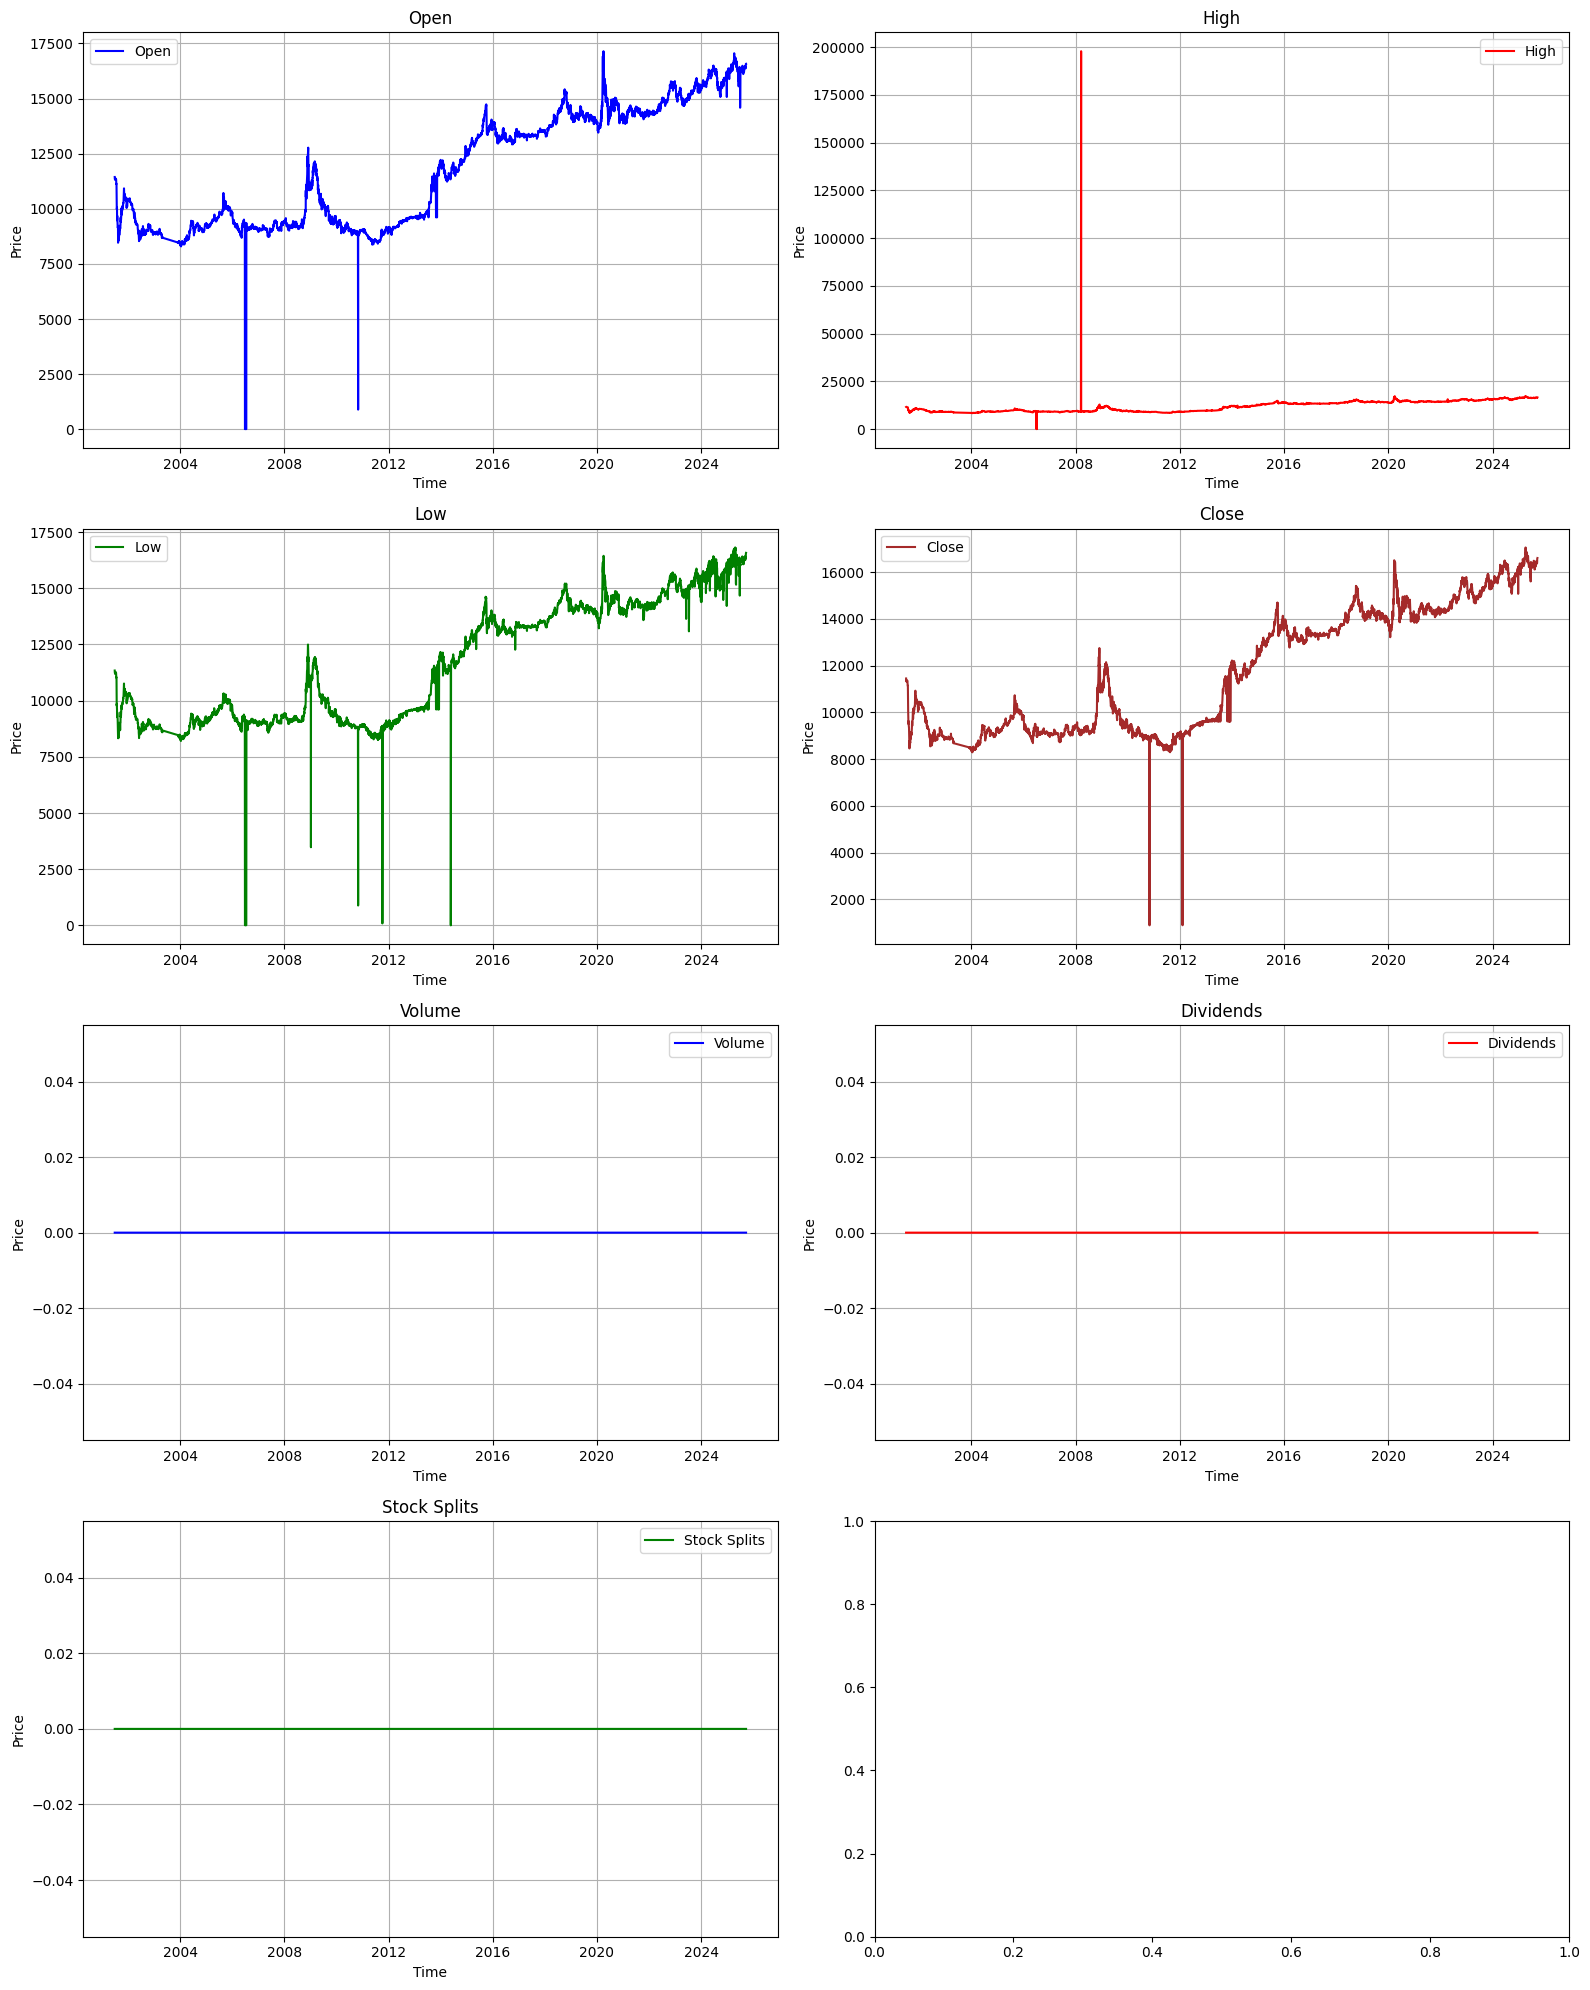

In [7]:
plot_series(idrx_history, columns=idrx_history.columns)

## Looking for 2002-2024 dataset range

In [8]:
idrx_2002_2024 = idrx_history.loc['2002-01-01':'2024-01-01']
idrx_2002_2024

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2002-01-02 00:00:00+00:00,10435.000000,10575.0,10295.000000,10415.000000,0,0.0,0.0
2002-01-03 00:00:00+00:00,10358.000000,10500.0,10258.000000,10375.000000,0,0.0,0.0
2002-01-04 00:00:00+00:00,10428.000000,10600.0,10195.000000,10428.000000,0,0.0,0.0
2002-01-07 00:00:00+00:00,10390.000000,10528.0,10290.000000,10390.000000,0,0.0,0.0
2002-01-08 00:00:00+00:00,10423.000000,10523.0,10323.000000,10423.000000,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-12-26 00:00:00+00:00,15460.000000,15460.0,15398.500000,15460.000000,0,0.0,0.0
2023-12-27 00:00:00+00:00,15400.000000,15434.0,15347.400391,15400.000000,0,0.0,0.0
2023-12-28 00:00:00+00:00,15373.000000,15443.0,15369.200195,15373.000000,0,0.0,0.0


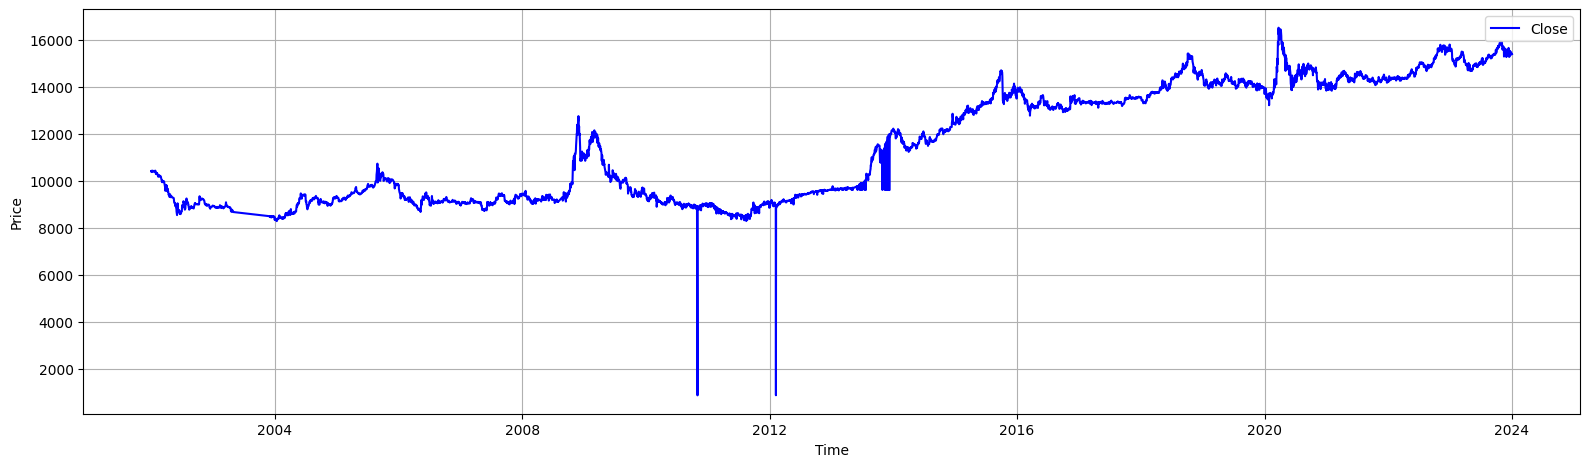

In [9]:
plot_series(idrx_2002_2024, columns=['Close'])

## Save loaded dataset to csv file

In [10]:
# save csv file
def save_csv(df, dir, download=False):
  '''
    All downloaded file will stored in download directory
  '''
  os.makedirs('download', exist_ok=True)
  print(f'Success make dir download')
  save_path = os.path.join('download', dir)
  df.to_csv(save_path)
  print(f'Success save {save_path} to /download{save_path}')

  if download:
    files.download(save_path)

# Uncomment code below for downloading the file
save_path = "usd_idr_historical_data_20y.csv"
# set download to False if you just want to save csv
save_csv(idrx_history, save_path, download=False)

Success make dir download
Success save download/usd_idr_historical_data_20y.csv to /downloaddownload/usd_idr_historical_data_20y.csv


## Load Dataset

In [11]:
dataset_path = '/kaggle/input/usd-idr-price-20y/usd_price_20y'
idrx_df = pd.read_csv(dataset_path, index_col='Date')
idrx_df.index = pd.to_datetime(idrx_df.index, utc=True)
idrx_df.index = pd.to_datetime(idrx_df.index.date)
# idrx_df.sort_values(by='Date', ascending=True, inplace=True)
idrx_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
2002-01-02,10435.000000,10575.0,10295.000000,10415.000000,0,0.0,0.0
2002-01-03,10358.000000,10500.0,10258.000000,10375.000000,0,0.0,0.0
2002-01-04,10428.000000,10600.0,10195.000000,10428.000000,0,0.0,0.0
2002-01-07,10390.000000,10528.0,10290.000000,10390.000000,0,0.0,0.0
2002-01-08,10423.000000,10523.0,10323.000000,10423.000000,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-12-26,15460.000000,15460.0,15398.500000,15460.000000,0,0.0,0.0
2023-12-27,15400.000000,15434.0,15347.400391,15400.000000,0,0.0,0.0
2023-12-28,15373.000000,15443.0,15369.200195,15373.000000,0,0.0,0.0
2023-12-29,15425.000000,15536.5,14416.500000,15425.000000,0,0.0,0.0


In [12]:
idrx_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5542 entries, 2002-01-02 to 2024-01-01
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          5542 non-null   float64
 1   High          5542 non-null   float64
 2   Low           5542 non-null   float64
 3   Close         5542 non-null   float64
 4   Volume        5542 non-null   int64  
 5   Dividends     5542 non-null   float64
 6   Stock Splits  5542 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 346.4 KB


In [13]:
for col in idrx_df.columns:
  print(f'{col}: {idrx_df[col].nunique()}')

Open: 4393
High: 4409
Low: 4177
Close: 4355
Volume: 1
Dividends: 1
Stock Splits: 1


`Volume`, `Dividends`, `Stock Splits` does not give much information, so we'll drop it

In [14]:
idrx_df.drop(columns=['Volume', 'Dividends', 'Stock Splits'], inplace=True)
idrx_df

,Open,High,Low,Close
2002-01-02,10435.000000,10575.0,10295.000000,10415.000000
2002-01-03,10358.000000,10500.0,10258.000000,10375.000000
2002-01-04,10428.000000,10600.0,10195.000000,10428.000000
2002-01-07,10390.000000,10528.0,10290.000000,10390.000000
2002-01-08,10423.000000,10523.0,10323.000000,10423.000000
...,...,...,...,...
2023-12-26,15460.000000,15460.0,15398.500000,15460.000000
2023-12-27,15400.000000,15434.0,15347.400391,15400.000000
2023-12-28,15373.000000,15443.0,15369.200195,15373.000000
2023-12-29,15425.000000,15536.5,14416.500000,15425.000000


Much better! :)

Now we'll look into the moving data point in each columns

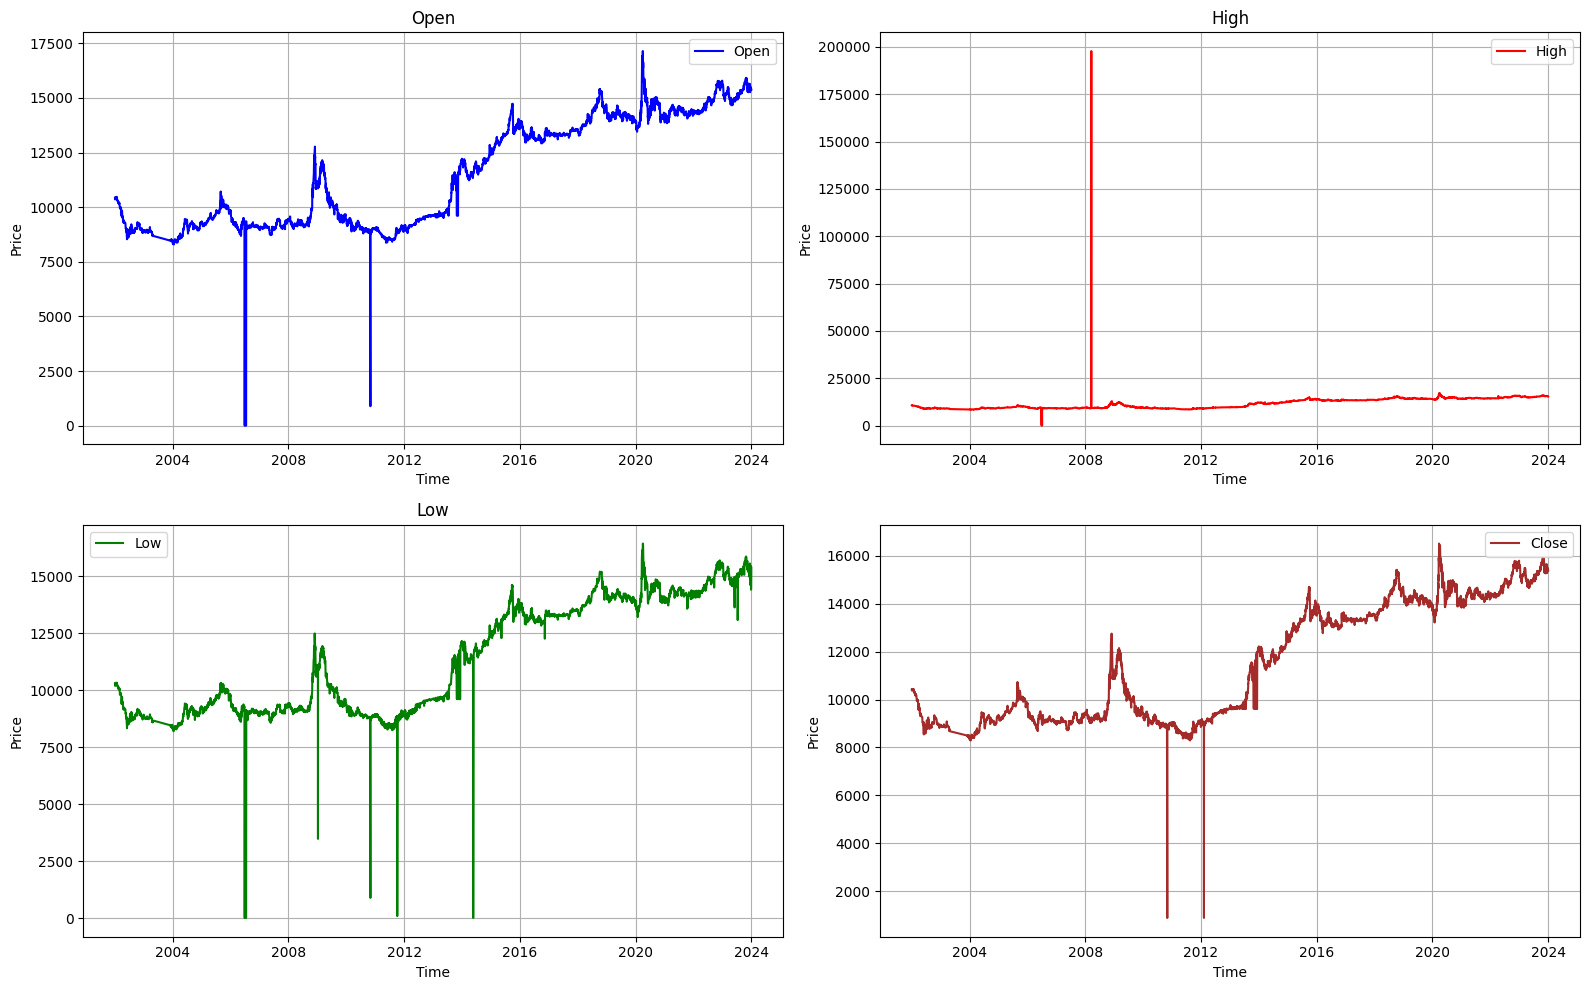

In [15]:
plot_series(idrx_df, columns=idrx_df.columns)

Looks there is outlier in value, and we should handle it later

# Preprocessing

## Check for missing value

In [16]:
idrx_df.isnull().sum()

Open     0
High     0
Low      0
Close    0
dtype: int64

## Handling the outlier

As seen above, we found the outlier of the dataset, it'll make trained model not performing well. Now we'll look up the case. <br>
The oulier seems happened between 2010 and 2013. But there is different outlier in each columns. Instead, we're going to set the upper and lower bound, which will return value between 5000 and 30000

In [17]:
idrx_df = idrx_df[
    (idrx_df['Close'] > 5000) & (idrx_df['Close'] < 30000) &
     (idrx_df['Open'] > 5000) & (idrx_df['Open'] < 30000) &
      (idrx_df['High'] > 5000) & (idrx_df['High'] < 30000) &
       (idrx_df['Low'] > 5000) &(idrx_df['High'] < 30000)
       ]
idrx_df

,Open,High,Low,Close
2002-01-02,10435.000000,10575.0,10295.000000,10415.000000
2002-01-03,10358.000000,10500.0,10258.000000,10375.000000
2002-01-04,10428.000000,10600.0,10195.000000,10428.000000
2002-01-07,10390.000000,10528.0,10290.000000,10390.000000
2002-01-08,10423.000000,10523.0,10323.000000,10423.000000
...,...,...,...,...
2023-12-26,15460.000000,15460.0,15398.500000,15460.000000
2023-12-27,15400.000000,15434.0,15347.400391,15400.000000
2023-12-28,15373.000000,15443.0,15369.200195,15373.000000
2023-12-29,15425.000000,15536.5,14416.500000,15425.000000


DONE! <br>
Now if we plot the chart again.

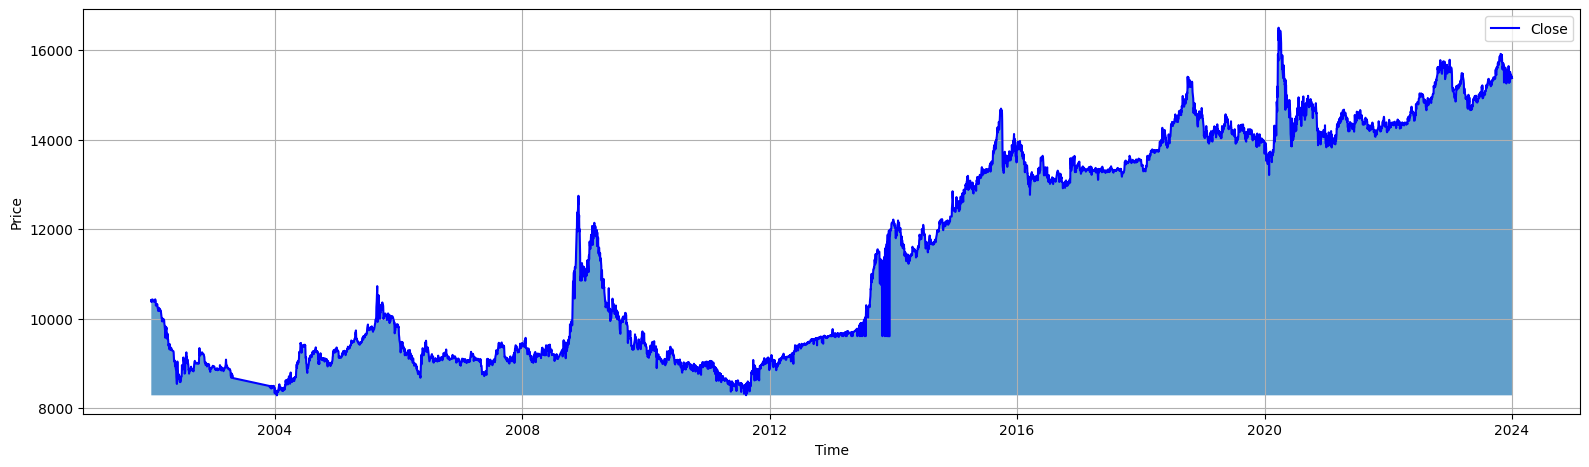

In [18]:
plot_series(idrx_df, columns=['Close'], fillbar=True)

Looks better! And now can we see the significant change of price rate from 2002 to 2024


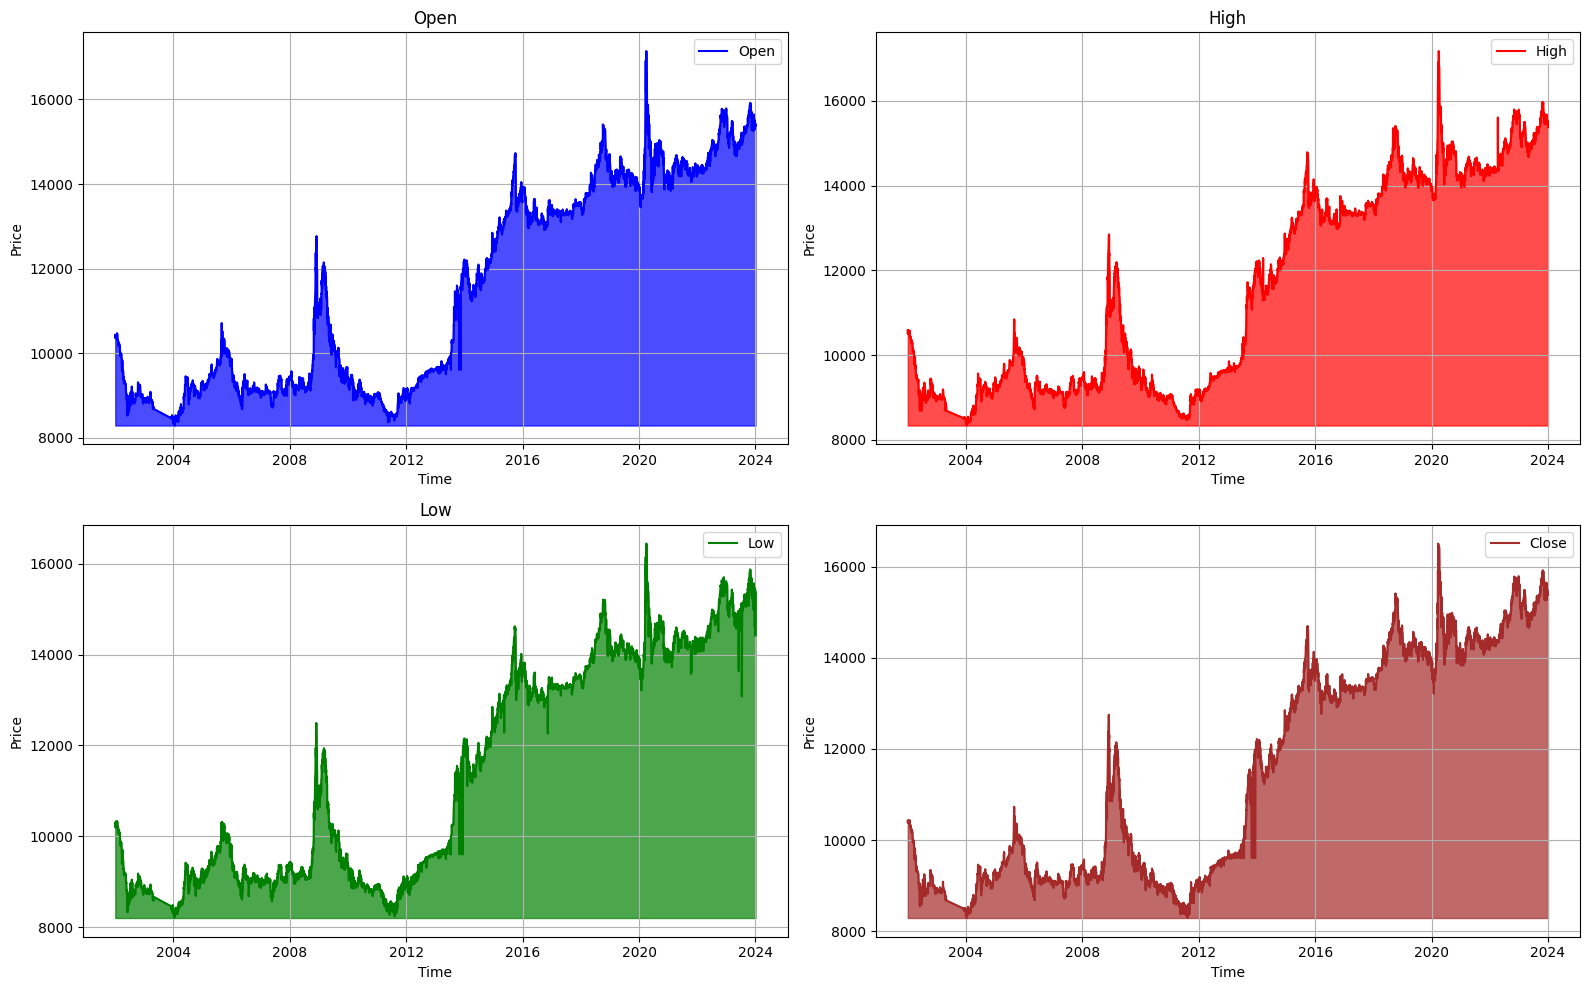

In [19]:
plot_series(idrx_df, columns=idrx_df.columns, fillbar=True)

Now they're looks cleaner

## Split data

Here we're going to split the dataset into train and valid dataset. Where each will be differenced dataset (stationary) and original dataset (non-stationary), which both would be trained and compared their accuracy to receive a better model

In [20]:
split_time = int(len(idrx_df) * 0.2)
train_series = idrx_df[:-split_time]
valid_series = idrx_df[-split_time:]
len(train_series), len(valid_series)

(4418, 1104)

### train test series

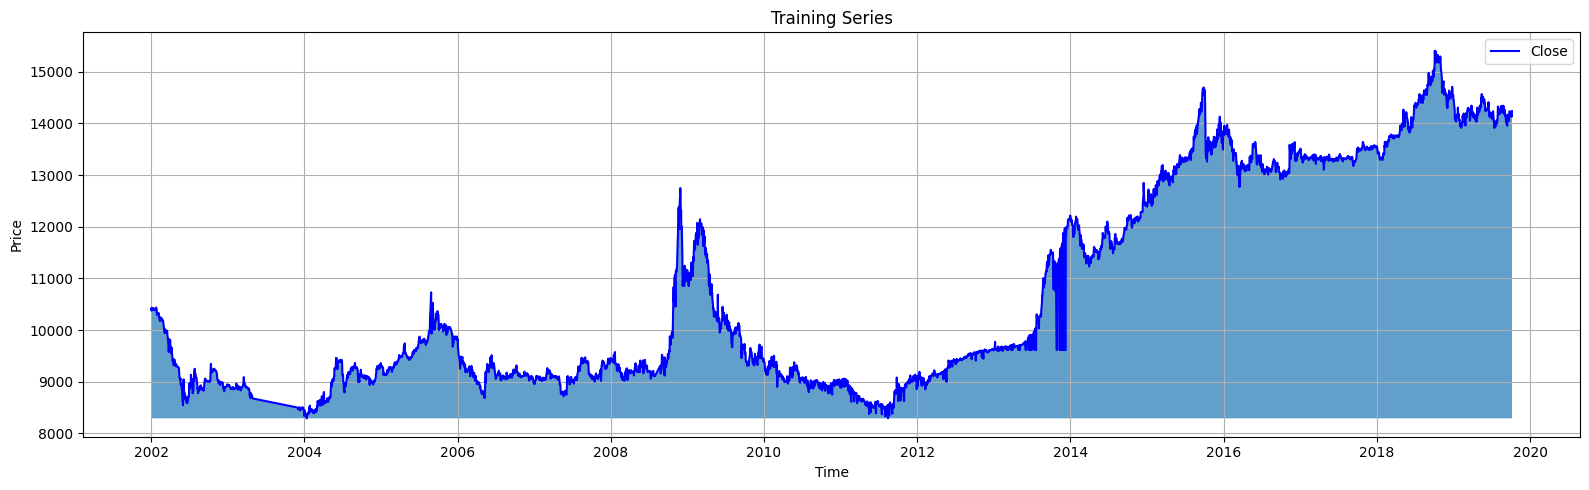

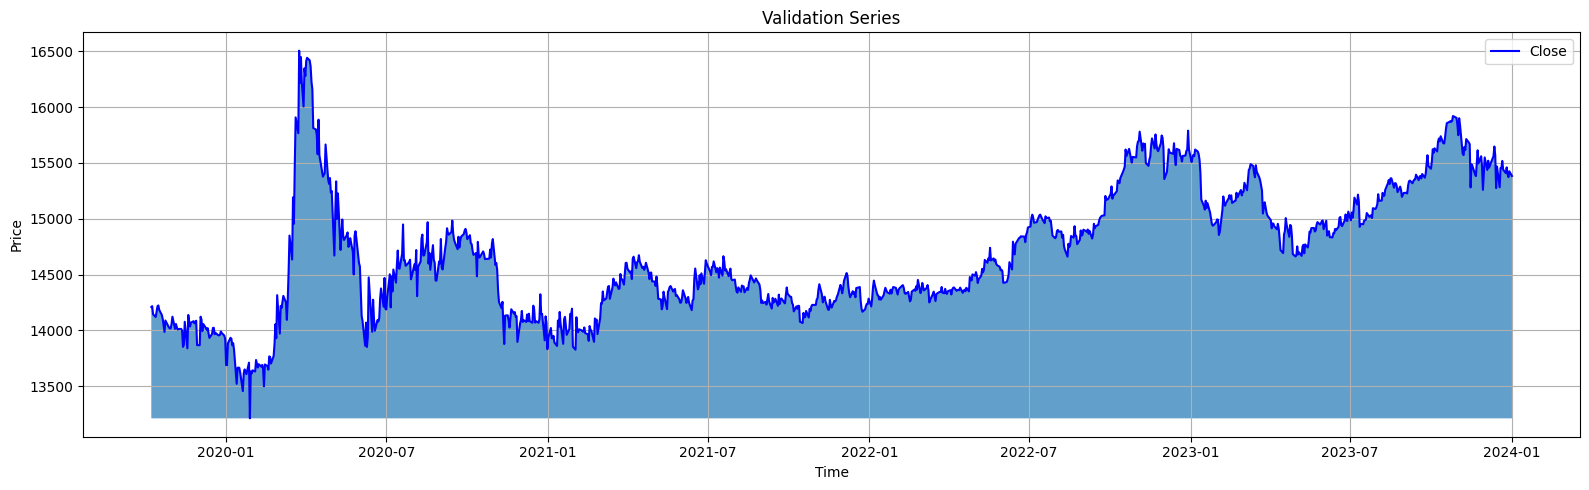

In [21]:
# plot train series
plot_series(train_series, ['Close'], fillbar=True, title='Training Series')

# plot validation series
plot_series(valid_series, ['Close'], fillbar=True, title='Validation Series')

In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(1e-1, 1))

train_scaled = scaler.fit_transform(np.expand_dims(train_series['Close'].to_numpy(), axis=-1))
valid_scaled = scaler.transform(np.expand_dims(valid_series['Close'].to_numpy(), axis=-1))

print('train values: {}'.format(train_series['Close'].to_numpy()))
print('train values scaled: {}'.format(train_scaled.flatten()))

train values: [10415.  10375.  10428.  ... 14166.  14128.  14239.5]
train values scaled: [0.36868655 0.36362987 0.37032997 ... 0.84287637 0.83807253 0.85216802]


# Windowing Data Series
The data of time series sequence need to be windowed to feed them into the Neural Network model. We'll take the features and the targets to be trained, which respectively to the X (features), y (targets) variables. The window_size is the size of feauters that determines how much the sequences will considered as a features to be trained and be fitted to the targets. The steps would be executed as follow:

- We'll take the 30 days of the sequence for features to predicts the next 30 days as a targets. It means that the rows of the dataset will be like (30, 30).

In [23]:
def windowed_dataset(series, window_size, target_size, batch_size, shuffle_buffer):
  # series = tf.expand_dims(series, axis=-1)

  # create tf dataset
  dataset = tf.data.Dataset.from_tensor_slices(series)

  # windowed dataset as window size
  dataset = dataset.window(window_size+target_size, shift=1, drop_remainder=True)
  # flat the window
  dataset = dataset.flat_map(lambda window : window.batch(window_size+target_size))

  # shuffle the dataset
  if shuffle_buffer:
      dataest = dataset.shuffle(shuffle_buffer)

  # map the window to input and target value
  dataset = dataset.map(lambda window: (window[:-target_size], window[-target_size:]))

  # batching the dataset and prefetch 1 data point
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [24]:
BATCH_SIZE = 10
WINDOW_SIZE = 15 # will be explore more and fine tuned the value
TARGET_SIZE = 1
SHUFFLE_BUFFER = len(train_series)

train_windowed = windowed_dataset(train_scaled, window_size=WINDOW_SIZE, target_size=TARGET_SIZE, batch_size=BATCH_SIZE, shuffle_buffer=SHUFFLE_BUFFER)
valid_windowed = windowed_dataset(valid_scaled, window_size=WINDOW_SIZE, target_size=TARGET_SIZE, batch_size=BATCH_SIZE, shuffle_buffer=None)

I0000 00:00:1758533576.188975      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [25]:
for j, data in enumerate(train_windowed.take(1)):
  # Look up the 5 first training datasetes from batch 1 and 2
  # print(f'\n\033[1mBATCH: {j}\033[0m '.ljust(50, '-'))
  print('Batch shape: {}'.format(data[0].shape))
  print('Target shape: {}'.format(data[1].shape))
  # for i in range(2):
  #   print(f'\033[32mseries\033[0m: {data[0][i].numpy().shape}\n\033[31mtarget\033[0m: {data[1][i].numpy().shape}')

Batch shape: (10, 15, 1)
Target shape: (10, 1, 1)


# Build the model

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 15, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 15, 100)             │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ con1d_1 (Conv1D)                     │ (None, 15, 80)              │          80,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool1d_1 (MaxPooling1D)          │ (None, 1, 80)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 80)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │           8,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 129,081 (504.22 KB)

 Trainable params: 129,081 (504.22 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 15, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 15, 100)             │          30,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ con1d_1 (Conv1D)                     │ (None, 15, 80)              │          80,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool1d_1 (MaxPooling1D)          │ (None, 1, 80)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 80)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │           8,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 119,181 (465.55 KB)

 Trainable params: 119,181 (465.55 KB)

 Non-trainable params: 0 (0.00 B)

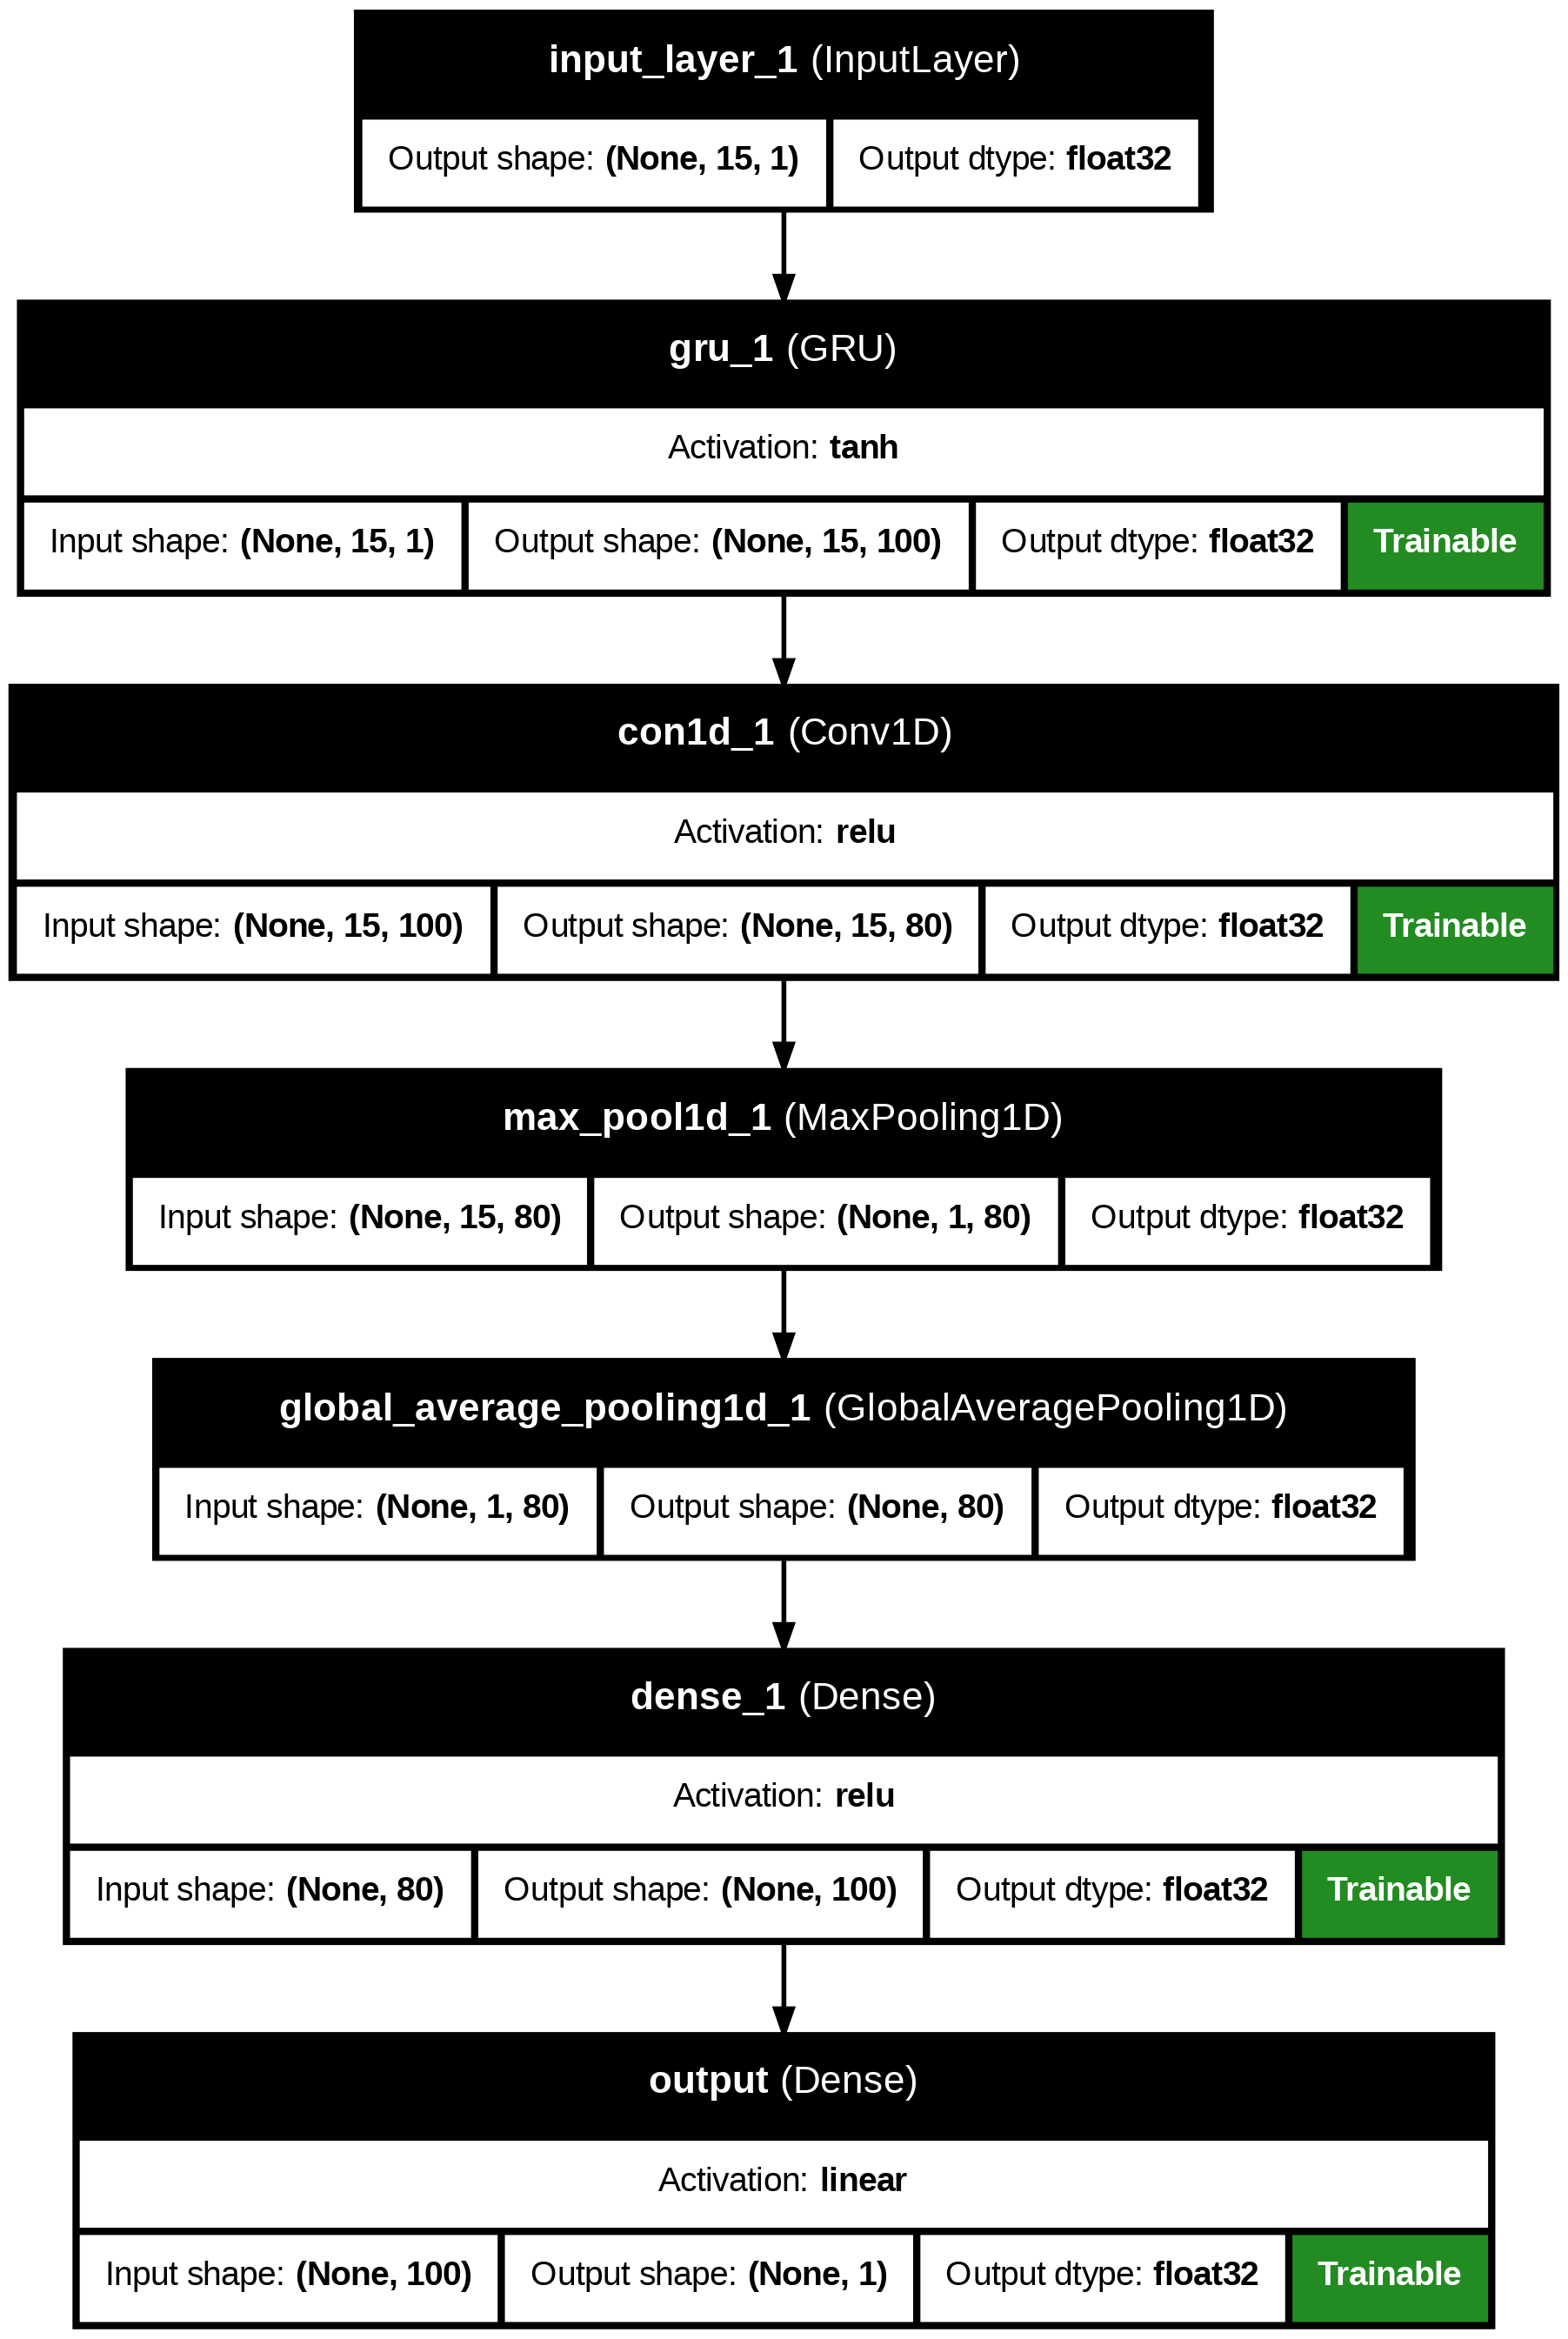

In [26]:
# build network architecture

# defein rnn method to compare
LSTM_NET = LSTM(100, return_sequences=True, name='lstm_1')
GRU_NET = GRU(100, return_sequences=True, name='gru_1')

def build_temporal_network(rnn):
    input_l = Input(shape=(WINDOW_SIZE, 1))

    # LSTM Layer
    rnn = rnn(input_l)

    # CONV1D Layer
    conv1d = Conv1D(filters=80, kernel_size=10, name='con1d_1', strides=1, padding='causal', activation='relu')(rnn)

    # Pooling layer
    max_pool1d = MaxPooling1D(10, name='max_pool1d_1')(conv1d)

    # Flattened layer
    flattened_l = GlobalAveragePooling1D()(max_pool1d)

    # Dense layer
    dense = Dense(100, activation='relu', name='dense_1')(flattened_l)
    # dense = Dense(50, activation='relu', name='dense_2')(dense)
    output_l = Dense(TARGET_SIZE, name='output')(dense)

    model = tf.keras.Model(inputs=input_l, outputs=output_l)
    return model


# build model
LR = 5e-5
MOMENTUM=0.9
METRICS = [tf.keras.losses.MeanAbsoluteError(name='mae'), tf.keras.metrics.RootMeanSquaredError(name='rmse')]
PLOT_MODEL = False
SUMMARY = True

def build_model(model, lr=LR, momentum=MOMENTUM, metrics=METRICS, plot_model=PLOT_MODEL, summary=SUMMARY):
    model.compile(
        loss=tf.keras.losses.Huber(),
        optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum),
        metrics=metrics
    )

    if plot_model:
        tf.keras.utils.plot_model(model, to_file='model_graph.png', show_shapes=True)

    if summary:
        model.summary()

    return model


model_lstm = build_model(build_temporal_network(LSTM_NET))
model_gru = build_model(build_temporal_network(GRU_NET))

# plot model architecture
tf.keras.utils.plot_model(
    model_lstm, 
    to_file='model_graph_lstm_base.png', 
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=200,
    show_layer_activations=True,
    show_trainable=True
)


tf.keras.utils.plot_model(
    model_gru, 
    to_file='model_graph_gru_base.png', 
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=200,
    show_layer_activations=True,
    show_trainable=True
)

# Train The Model

In [27]:
# set Callbacks
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_rmse',
    factor=0.1,
    patience=5,
    verbose=3,
    mode='min',
    min_delta=0.00001,
    cooldown=0,
    min_lr=0.00001,
)

In [28]:
# Fit the model
history_lstm = model_lstm.fit(train_windowed,
                         epochs=50,
                         validation_data=valid_windowed,
                         batch_size=BATCH_SIZE, callbacks=[lr_reducer])


Epoch 1/50


I0000 00:00:1758533580.918701      75 cuda_dnn.cc:529] Loaded cuDNN version 90300


    441/Unknown 6s 4ms/step - loss: 0.0321 - mae: 0.2251 - rmse: 0.2470

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


441/441 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0321 - mae: 0.2253 - rmse: 0.2473 - val_loss: 0.2151 - val_mae: 0.6466 - val_rmse: 0.6559 - learning_rate: 5.0000e-05
Epoch 2/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0085 - mae: 0.0751 - rmse: 0.1128 - val_loss: 0.1395 - val_mae: 0.5195 - val_rmse: 0.5282 - learning_rate: 5.0000e-05
Epoch 3/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0072 - mae: 0.0914 - rmse: 0.1115 - val_loss: 0.1023 - val_mae: 0.4440 - val_rmse: 0.4524 - learning_rate: 5.0000e-05
Epoch 4/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0099 - mae: 0.1247 - rmse: 0.1380 - val_loss: 0.0824 - val_mae: 0.3976 - val_rmse: 0.4060 - learning_rate: 5.0000e-05
Epoch 5/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0124 - mae: 0.1459 - rmse: 0.1560 - val_loss: 0.0710 - val_mae: 0.3686 - val_rmse: 0.3769 - learning_rate: 5.0000e-05
Epoch 6/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0139 - mae: 0.1566 - rmse: 0.1656 - val_loss: 0.0

In [29]:
# Fit the model
history_gru = model_gru.fit(train_windowed,
                         epochs=50,
                         validation_data=valid_windowed,
                         batch_size=BATCH_SIZE, callbacks=[lr_reducer])


Epoch 1/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0356 - mae: 0.2378 - rmse: 0.2038 - val_loss: 0.2335 - val_mae: 0.6741 - val_rmse: 0.6834 - learning_rate: 5.0000e-05
Epoch 2/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0105 - mae: 0.0932 - rmse: 0.1290 - val_loss: 0.1511 - val_mae: 0.5411 - val_rmse: 0.5496 - learning_rate: 5.0000e-05
Epoch 3/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0063 - mae: 0.0747 - rmse: 0.0993 - val_loss: 0.1063 - val_mae: 0.4530 - val_rmse: 0.4611 - learning_rate: 5.0000e-05
Epoch 4/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0075 - mae: 0.1027 - rmse: 0.1181 - val_loss: 0.0807 - val_mae: 0.3939 - val_rmse: 0.4018 - learning_rate: 5.0000e-05
Epoch 5/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0096 - mae: 0.1259 - rmse: 0.1366 - val_loss: 0.0653 - val_mae: 0.3536 - val_rmse: 0.3614 - learning_rate: 5.0000e-05
Epoch 6/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0111 - mae: 0.1397 - rmse: 0.1482 - va

In [30]:
model_lstm.save("lstm_01.keras")
model_gru.save("gru_01.keras")

In [31]:
def compare_forecast_on_df(history, series, windowed_series, save_csv: str = None):
    forecast = history.model.predict(windowed_series)
    forecast = scaler.inverse_transform(forecast)
    forecast = np.mean(np.array(forecast), axis=1)
    print(forecast.shape)
    
    forecast_df = pd.DataFrame(series['Close'][WINDOW_SIZE:])
    forecast_df['Close_Forecast'] = forecast

    if save_csv != None:
        forecast_df.to_csv(save_csv)
    return forecast_df

In [32]:
forecast_lstm_train_df = compare_forecast_on_df(history_lstm, train_series, train_windowed, save_csv='train_forecast_lstm.csv')
forecast_lstm_valid_df = compare_forecast_on_df(history_lstm, valid_series, valid_windowed, save_csv='valid_forecast_lstm.csv')

forecast_gru_train_df = compare_forecast_on_df(history_gru, train_series, train_windowed, save_csv='train_forecast_gru.csv')
forecast_gru_valid_df = compare_forecast_on_df(history_gru, valid_series, valid_windowed, save_csv='valid_forecast_gru.csv')

display(forecast_lstm_train_df)
display(forecast_lstm_valid_df)

display(forecast_gru_train_df)
display(forecast_gru_valid_df)

441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(4403,)
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
(1089,)


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(4403,)
      1/Unknown 0s 13ms/step

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
(1089,)


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


,Close,Close_Forecast
2002-01-23,10400.0,10526.540039
2002-01-24,10385.0,10525.083984
2002-01-25,10435.0,10526.423828
2002-01-28,10385.0,10523.180664
2002-01-29,10295.0,10522.378906
...,...,...
2019-10-01,14206.0,13948.591797
2019-10-02,14188.0,13955.600586
2019-10-03,14166.0,13963.695312
2019-10-06,14128.0,13981.310547


,Close,Close_Forecast
2019-10-30,14018.000000,14028.932617
2019-10-31,14060.000000,14020.208984
2019-11-01,14123.500000,14006.801758
2019-11-04,14014.000000,13997.522461
2019-11-05,14058.000000,13988.025391
...,...,...
2023-12-26,15460.000000,15045.357422
2023-12-27,15400.000000,15033.447266
2023-12-28,15373.000000,15032.175781
2023-12-29,15425.000000,15026.333008


,Close,Close_Forecast
2002-01-23,10400.0,10475.703125
2002-01-24,10385.0,10476.462891
2002-01-25,10435.0,10478.101562
2002-01-28,10385.0,10475.564453
2002-01-29,10295.0,10474.106445
...,...,...
2019-10-01,14206.0,14028.653320
2019-10-02,14188.0,14036.324219
2019-10-03,14166.0,14044.793945
2019-10-06,14128.0,14063.436523


,Close,Close_Forecast
2019-10-30,14018.000000,14115.818359
2019-10-31,14060.000000,14108.288086
2019-11-01,14123.500000,14097.437500
2019-11-04,14014.000000,14091.834961
2019-11-05,14058.000000,14080.576172
...,...,...
2023-12-26,15460.000000,15179.381836
2023-12-27,15400.000000,15170.176758
2023-12-28,15373.000000,15165.617188
2023-12-29,15425.000000,15154.101562


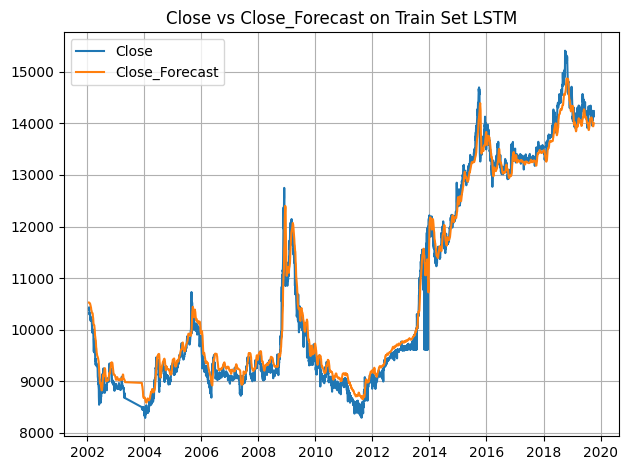

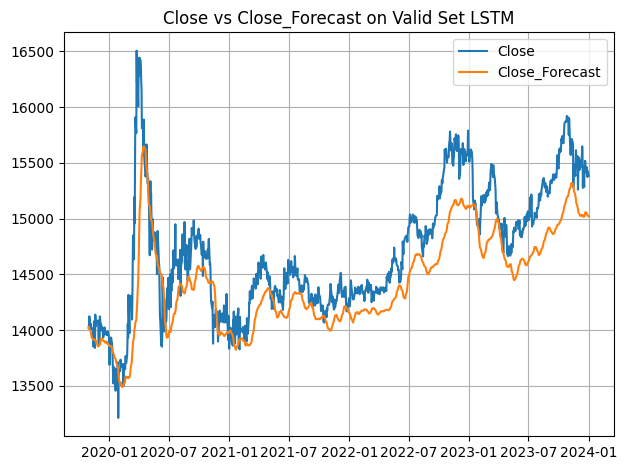

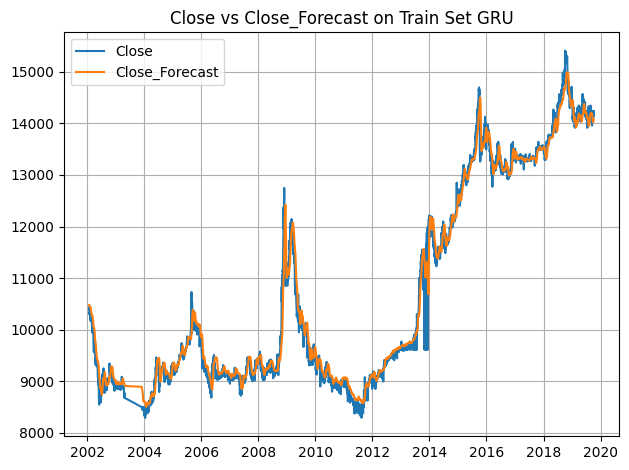

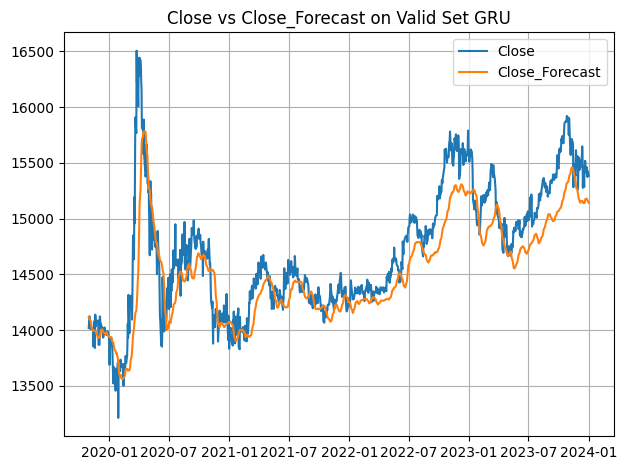

In [33]:
plot_compare(forecast_lstm_train_df, list(forecast_lstm_train_df.columns), title='Close vs Close_Forecast on Train Set LSTM', save_fig='close_vs_close_forecast_train_set_lstm.png')
plot_compare(forecast_lstm_valid_df, list(forecast_lstm_valid_df.columns), title='Close vs Close_Forecast on Valid Set LSTM', save_fig='close_vs_close_forecast_valid_set_lstm.png')

plot_compare(forecast_gru_train_df, list(forecast_gru_train_df.columns), title='Close vs Close_Forecast on Train Set GRU', save_fig='close_vs_close_forecast_train_set_gru.png')
plot_compare(forecast_gru_valid_df, list(forecast_gru_valid_df.columns), title='Close vs Close_Forecast on Valid Set GRU', save_fig='close_vs_close_forecast_valid_set_gru.png')

# Hyperparameters Tuning with Keras Tuner

In [34]:
class TemporalHyperModel(keras_tuner.HyperModel):
    def __init__(self, key):
        self.key = key

    
    def build_temporal_network(self, key, units, c_filters, lr, dropout):
        input_l = Input(shape=(WINDOW_SIZE, 1))
    
        # RNN Layer
        if key == 'lstm':
            rnn = LSTM(units, return_sequences=True, name='lstm_1')(input_l)
        elif key == 'gru':
            rnn = GRU(units, return_sequences=True, name='gru_1')(input_l)
        else:
            raise NameError("key is str, the value must be either 'lstm' or 'gru'")
    
        # CONV1D Layer
        conv1d = Conv1D(filters=c_filters, kernel_size=7, name='conf1d_1', strides=1, padding='causal', activation='relu')(rnn)
    
        # Pooling layer
        max_pool1d = MaxPooling1D(10, name='max_pool1d_1')(conv1d)
    
        # Flattened layer
        flattened_l = GlobalAveragePooling1D()(max_pool1d)
    
        # add dropout if necessary
        if dropout:
            flattened_l = Dropout(0.25)(flattened_l)
    
        # Dense layer
        dense = Dense(units, activation='relu', name='dense_1')(flattened_l)
    
        output_l = Dense(1, name='output')(dense)
    
        model = tf.keras.Model(inputs=input_l, outputs=output_l)
    
        model.compile(
            loss=tf.keras.losses.Huber(),
            optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
            metrics=METRICS
        )
        
        return model


    def build(self, hp):
        rnn_key = self.key
        units = hp.Int('units', min_value=50, max_value=200, step=50)
        c_filters = hp.Int('c_filters', min_value=50, max_value=100, step=25)
        lr = hp.Choice('lr', [5e-5, 5e-4])
        dropout = hp.Boolean("dropout")
        
        model = self.build_temporal_network(rnn_key, units, c_filters, lr, dropout)
        return model

In [35]:
model_lstm_tuner = TemporalHyperModel(key='lstm')
model_gru_tuner = TemporalHyperModel(key='gru')

## Keras Tuner

In [36]:
lstm_tuner = keras_tuner.GridSearch(
    hypermodel=TemporalHyperModel('lstm'),
    objective=keras_tuner.Objective('val_rmse', direction='min'),
    max_trials=None,
    executions_per_trial=1,
    overwrite=False,
    directory="lstm_tuner",
    project_name="usdidr_prediction_bayes_lstm_11",
)

gru_tuner = keras_tuner.GridSearch(
    hypermodel=TemporalHyperModel('gru'),
    objective=keras_tuner.Objective('val_rmse', direction='min'),
    max_trials=None,
    executions_per_trial=1,
    overwrite=False,
    directory="gru_tuner",
    project_name="usdidr_prediction_bayes_gru_11",
)

In [37]:
lstm_tuner.search_space_summary()
gru_tuner.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 200, 'step': 50, 'sampling': 'linear'}
c_filters (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 100, 'step': 25, 'sampling': 'linear'}
lr (Choice)
{'default': 5e-05, 'conditions': [], 'values': [5e-05, 0.0005], 'ordered': True}
dropout (Boolean)
{'default': False, 'conditions': []}
Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 200, 'step': 50, 'sampling': 'linear'}
c_filters (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 100, 'step': 25, 'sampling': 'linear'}
lr (Choice)
{'default': 5e-05, 'conditions': [], 'values': [5e-05, 0.0005], 'ordered': True}
dropout (Boolean)
{'default': False, 'conditions': []}


### **Start Tuning**

In [38]:
# @title LSTM model Tuning
lstm_tuner.search(train_windowed, epochs=10, validation_data=valid_windowed)

Trial 48 Complete [00h 00m 26s]
val_rmse: 0.03561553359031677

Best val_rmse So Far: 0.03403131663799286
Total elapsed time: 00h 20m 10s


In [39]:
# @title GRU model Tuning
gru_tuner.search(train_windowed, epochs=10, validation_data=valid_windowed)

Trial 48 Complete [00h 00m 27s]
val_rmse: 0.0385642945766449

Best val_rmse So Far: 0.03332000970840454
Total elapsed time: 00h 20m 26s


### **End Tuning**

In [40]:
lstm_tuner.results_summary()
gru_tuner.results_summary()

Results summary
Results in lstm_tuner/usdidr_prediction_bayes_lstm_11
Showing 10 best trials
Objective(name="val_rmse", direction="min")

Trial 0035 summary
Hyperparameters:
units: 150
c_filters: 100
lr: 0.0005
dropout: True
Score: 0.03403131663799286

Trial 0043 summary
Hyperparameters:
units: 200
c_filters: 75
lr: 0.0005
dropout: True
Score: 0.0350683219730854

Trial 0034 summary
Hyperparameters:
units: 150
c_filters: 100
lr: 0.0005
dropout: False
Score: 0.035075679421424866

Trial 0030 summary
Hyperparameters:
units: 150
c_filters: 75
lr: 0.0005
dropout: False
Score: 0.03561456501483917

Trial 0047 summary
Hyperparameters:
units: 200
c_filters: 100
lr: 0.0005
dropout: True
Score: 0.03561553359031677

Trial 0023 summary
Hyperparameters:
units: 100
c_filters: 100
lr: 0.0005
dropout: True
Score: 0.03578783571720123

Trial 0022 summary
Hyperparameters:
units: 100
c_filters: 100
lr: 0.0005
dropout: False
Score: 0.03594350814819336

Trial 0014 summary
Hyperparameters:
units: 100
c_filters

In [41]:
lstm_models = lstm_tuner.get_best_models(num_models=1)
gru_models = gru_tuner.get_best_models(num_models=1)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 11 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [42]:
best_lstm_model = lstm_models[0]
best_gru_model = gru_models[0]

In [43]:
best_lstm_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 15, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 15, 150)             │          91,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conf1d_1 (Conv1D)                    │ (None, 15, 100)             │         105,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool1d_1 (MaxPooling1D)          │ (None, 1, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 100)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 150)                 │          15,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 211,601 (826.57 KB)

 Trainable params: 211,601 (826.57 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
best_gru_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 15, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 15, 50)              │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conf1d_1 (Conv1D)                    │ (None, 15, 75)              │          26,325 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool1d_1 (MaxPooling1D)          │ (None, 1, 75)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 75)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │           3,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,126 (148.93 KB)

 Trainable params: 38,126 (148.93 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
best_lstm_model.save('best_model_tuned_bayes_lstm_10.keras')
best_gru_model.save('best_model_tuned_bayes_gru_10.keras')

## End of keras tuning (be careful to run the code above)

In [46]:
best_lstm_hps = lstm_tuner.get_best_hyperparameters(5)
for hp in best_lstm_hps:
  print(hp.values)

{'units': 150, 'c_filters': 100, 'lr': 0.0005, 'dropout': True}
{'units': 200, 'c_filters': 75, 'lr': 0.0005, 'dropout': True}
{'units': 150, 'c_filters': 100, 'lr': 0.0005, 'dropout': False}
{'units': 150, 'c_filters': 75, 'lr': 0.0005, 'dropout': False}
{'units': 200, 'c_filters': 100, 'lr': 0.0005, 'dropout': True}


In [47]:
best_gru_hps = gru_tuner.get_best_hyperparameters(5)
for hp in best_gru_hps:
  print(hp.values)

{'units': 50, 'c_filters': 75, 'lr': 0.0005, 'dropout': False}
{'units': 50, 'c_filters': 50, 'lr': 0.0005, 'dropout': False}
{'units': 200, 'c_filters': 75, 'lr': 0.0005, 'dropout': True}
{'units': 50, 'c_filters': 100, 'lr': 0.0005, 'dropout': True}
{'units': 150, 'c_filters': 50, 'lr': 0.0005, 'dropout': False}


# Train the model

In [48]:
# Build the model with the best hp.
# best_lstm_model = model_lstm_tuner.build(best_lstm_hps[1])
# best_gru_model = model_gru_tuner.build(best_gru_hps[0])
tf.keras.config.enable_unsafe_deserialization()


best_lstm_model = tf.keras.models.load_model('/kaggle/input/models-thesis-0-03-v1/keras/default/1/best_model_tuned_bayes_lstm_10.keras')
best_gru_model = tf.keras.models.load_model('/kaggle/input/models-thesis-0-03-v1/keras/default/1/best_model_tuned_bayes_gru_10.keras')
best_lstm_model = build_model(best_lstm_model)
best_gru_model = build_model(best_gru_model)

print(best_lstm_model.summary(), best_gru_model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 11 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 15, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 15, 150)             │          91,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conf1d_1 (Conv1D)                    │ (None, 15, 75)              │          78,825 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool1d_1 (MaxPooling1D)          │ (None, 1, 75)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 75)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 75)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 150)                 │          11,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 181,576 (709.28 KB)

 Trainable params: 181,576 (709.28 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 15, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 15, 200)             │         121,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conf1d_1 (Conv1D)                    │ (None, 15, 100)             │         140,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool1d_1 (MaxPooling1D)          │ (None, 1, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 100)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 200)                 │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 282,301 (1.08 MB)

 Trainable params: 282,301 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 15, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 15, 150)             │          91,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conf1d_1 (Conv1D)                    │ (None, 15, 75)              │          78,825 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool1d_1 (MaxPooling1D)          │ (None, 1, 75)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 75)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 75)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 150)                 │          11,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 181,576 (709.28 KB)

 Trainable params: 181,576 (709.28 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 15, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 15, 200)             │         121,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conf1d_1 (Conv1D)                    │ (None, 15, 100)             │         140,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool1d_1 (MaxPooling1D)          │ (None, 1, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 100)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 200)                 │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 282,301 (1.08 MB)

 Trainable params: 282,301 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

None None


In [49]:
# @title Set Callbacks
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_rmse',
    factor=0.1,
    patience=5,
    verbose=3,
    mode='min',
    min_delta=1e-7,
    cooldown=0,
    min_lr=0.0001,
)

In [50]:
# @title Fit LSTM the model
history_tuned_lstm = best_lstm_model.fit(
    train_windowed,
    epochs=50,
    validation_data=valid_windowed,
    batch_size=BATCH_SIZE,
    callbacks=[lr_reducer]
)

Epoch 1/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 7.6927e-04 - mae: 0.0289 - rmse: 0.0395 - val_loss: 9.3384e-04 - val_mae: 0.0317 - val_rmse: 0.0432 - learning_rate: 5.0000e-05
Epoch 2/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 7.7166e-04 - mae: 0.0288 - rmse: 0.0389 - val_loss: 9.0515e-04 - val_mae: 0.0310 - val_rmse: 0.0425 - learning_rate: 5.0000e-05
Epoch 3/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 7.6843e-04 - mae: 0.0286 - rmse: 0.0388 - val_loss: 8.7931e-04 - val_mae: 0.0303 - val_rmse: 0.0419 - learning_rate: 5.0000e-05
Epoch 4/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 7.5246e-04 - mae: 0.0284 - rmse: 0.0384 - val_loss: 9.2679e-04 - val_mae: 0.0315 - val_rmse: 0.0431 - learning_rate: 5.0000e-05
Epoch 5/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 7.6840e-04 - mae: 0.0286 - rmse: 0.0387 - val_loss: 9.3788e-04 - val_mae: 0.0318 - val_rmse: 0.0433 - learning_rate: 5.0000e-05
Epoch 6/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 

In [51]:
# @title Fit GRU the model
history_tuned_gru = best_gru_model.fit(
    train_windowed,
    epochs=50,
    validation_data=valid_windowed,
    batch_size=BATCH_SIZE,
    callbacks=[lr_reducer]
)

Epoch 1/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0015 - mae: 0.0467 - rmse: 0.0498 - val_loss: 6.9674e-04 - val_mae: 0.0256 - val_rmse: 0.0373 - learning_rate: 5.0000e-05
Epoch 2/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 9.2086e-04 - mae: 0.0331 - rmse: 0.0425 - val_loss: 7.3308e-04 - val_mae: 0.0266 - val_rmse: 0.0383 - learning_rate: 5.0000e-05
Epoch 3/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 8.2814e-04 - mae: 0.0302 - rmse: 0.0403 - val_loss: 7.2769e-04 - val_mae: 0.0265 - val_rmse: 0.0381 - learning_rate: 5.0000e-05
Epoch 4/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 7.7454e-04 - mae: 0.0287 - rmse: 0.0389 - val_loss: 7.2896e-04 - val_mae: 0.0266 - val_rmse: 0.0382 - learning_rate: 5.0000e-05
Epoch 5/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 7.3528e-04 - mae: 0.0276 - rmse: 0.0378 - val_loss: 6.9771e-04 - val_mae: 0.0257 - val_rmse: 0.0374 - learning_rate: 5.0000e-05
Epoch 6/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 7.05

# **Save Final Model**

In [52]:
import os
import tempfile

# create temporary directory
MODELS_DIR = '/kaggle/working'
version = 1
export_path_lstm = os.path.join(MODELS_DIR, 'forecast_lstm', str(version))
export_path_gru = os.path.join(MODELS_DIR, 'forecast_gru', str(version))

# checking if the temp dir model already exists
if os.path.isdir(export_path_lstm):
    print('\nlstm model already existed, cleaning up')
    !rm -r {export_path_lstm}

if os.path.isdir(export_path_gru):
    print('\ngru model already existed, cleaning up')
    !rm -r {export_path_gru}

# export model
best_lstm_model.export(export_path_lstm)
best_gru_model.export(export_path_gru)

# print listed extracted files of each model
print("Exported models")
!ls -a {export_path_lstm}
!ls -a {export_path_gru}

Saved artifact at '/kaggle/working/forecast_lstm/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 15, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135140383795600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135140383792912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135140356392720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135140356392912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135140356393296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135140356391952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135140356394448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135140356394640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135140356395216: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved artifact at '/kaggle/working/forecast_gru/1'. The following endpoints ar

In [53]:
!zip -r /kaggle/working/forecast_lstm.zip /kaggle/working/forecast_lstm/1
!zip -r /kaggle/working/forecast_gru.zip /kaggle/working/forecast_gru/1

  adding: kaggle/working/forecast_lstm/1/ (stored 0%)
  adding: kaggle/working/forecast_lstm/1/saved_model.pb (deflated 84%)
  adding: kaggle/working/forecast_lstm/1/fingerprint.pb (stored 0%)
  adding: kaggle/working/forecast_lstm/1/assets/ (stored 0%)
  adding: kaggle/working/forecast_lstm/1/variables/ (stored 0%)
  adding: kaggle/working/forecast_lstm/1/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: kaggle/working/forecast_lstm/1/variables/variables.index (deflated 61%)
  adding: kaggle/working/forecast_gru/1/ (stored 0%)
  adding: kaggle/working/forecast_gru/1/saved_model.pb (deflated 84%)
  adding: kaggle/working/forecast_gru/1/fingerprint.pb (stored 0%)
  adding: kaggle/working/forecast_gru/1/assets/ (stored 0%)
  adding: kaggle/working/forecast_gru/1/variables/ (stored 0%)
  adding: kaggle/working/forecast_gru/1/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: kaggle/working/forecast_gru/1/variables/variables.index (deflated 60%)


In [54]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_history(history, save_history_to_csv: str = None):
    # This list contains all the metrics to be plotted, excluding validation metrics
    params_to_plot = [key for key in history.history.keys() if 'val' not in key]
    print(params_to_plot)
    epochs = range(len(history.history['loss']))

    # Determine the number of rows and columns for the subplots
    ncols = 2
    nrows = (len(params_to_plot) + ncols - 1) // ncols  # Calculate nrows to fit all plots
    fig, axs = plt.subplots(figsize=(16, 5 * nrows), ncols=ncols, nrows=nrows)

    # Flatten the axs array to make it easy to iterate
    # Check if axs is a single object or an array
    if nrows == 1 and ncols == 1:
        axs = [axs]
    else:
        axs = axs.flatten()

    # Iterate over the non-validation parameters and plot them
    for i, param in enumerate(params_to_plot):
        axs[i].set_title(param)
        
        # Check if the validation key exists before plotting
        val_key = f'val_{param}'
        if val_key in history.history:
            axs[i].plot(epochs, history.history[val_key], label=val_key)
        
        axs[i].plot(epochs, history.history[param], label=param)
        axs[i].set_xlabel('Epochs')
        axs[i].set_ylabel('Value') 
        axs[i].grid(True)
        axs[i].legend()

    # Hide any unused subplots to prevent blank plots
    for i in range(len(params_to_plot), len(axs)):
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.show()

    if save_history_to_csv:
        # Create a DataFrame from the history dictionary
        df_history = pd.DataFrame(history.history)
        
        # Add the epochs column
        df_history['epochs'] = df_history.index
        
        # Save the DataFrame to a CSV file
        df_history.to_csv(save_history_to_csv, index=False)
        print(f"History saved to {save_history_to_csv}")

['loss', 'mae', 'rmse', 'learning_rate']


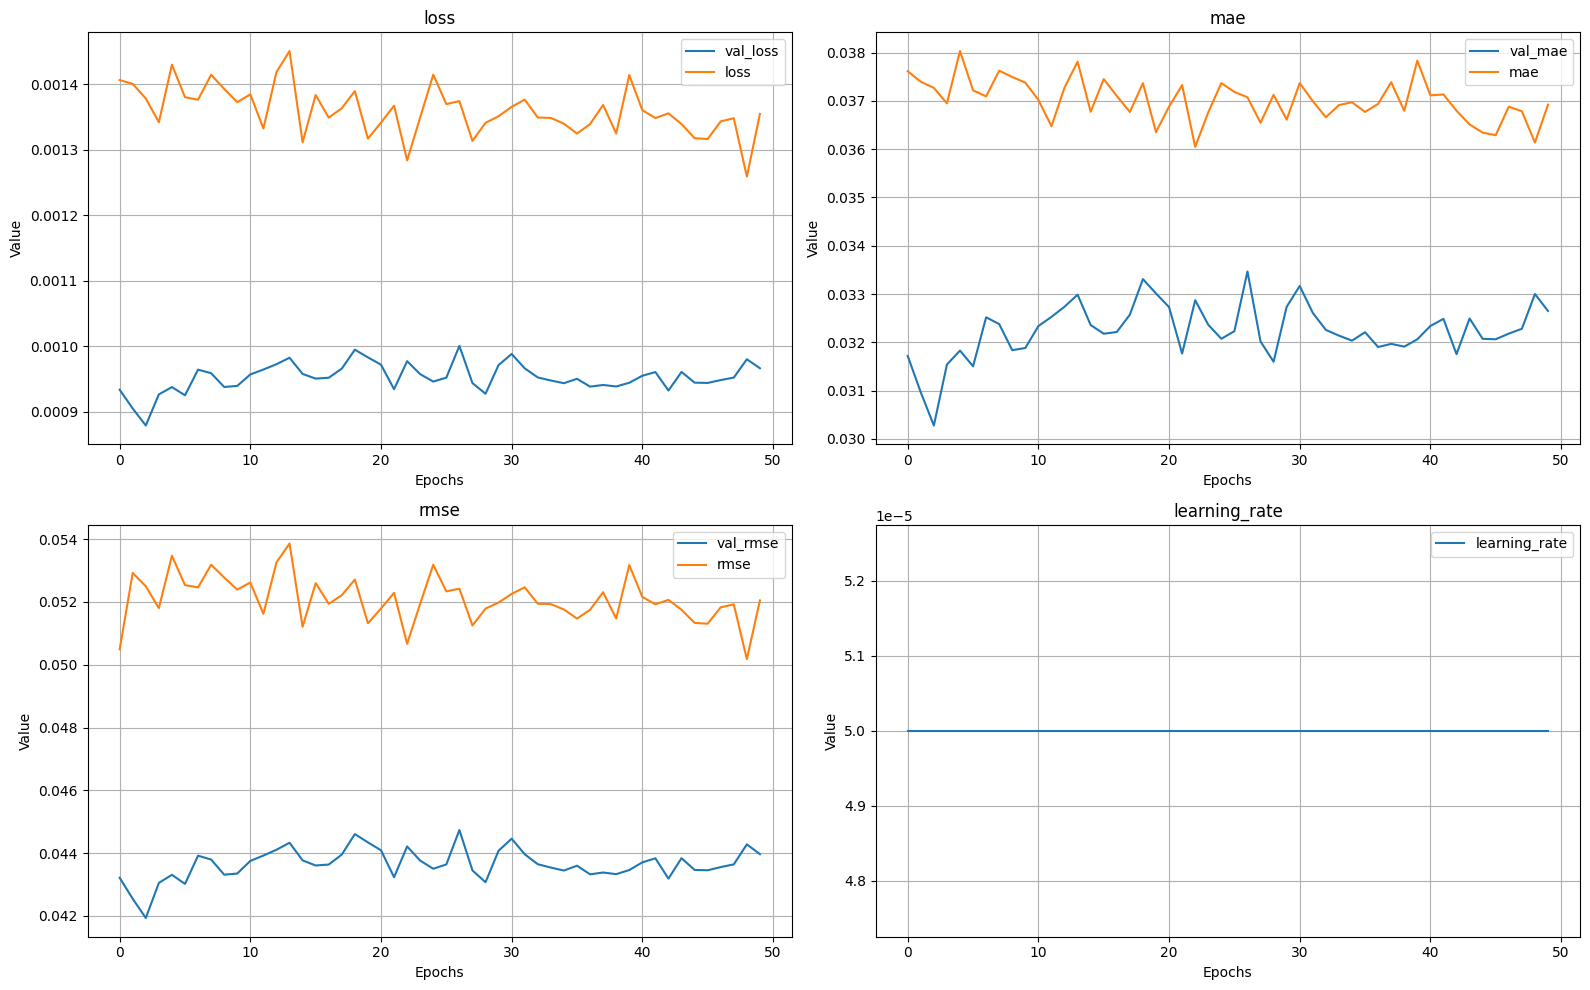

History saved to best_lstm_history.csv


In [55]:
# @title Learning History of LSTM and GRU
plot_history(history_tuned_lstm, save_history_to_csv='best_lstm_history.csv')

['loss', 'mae', 'rmse', 'learning_rate']


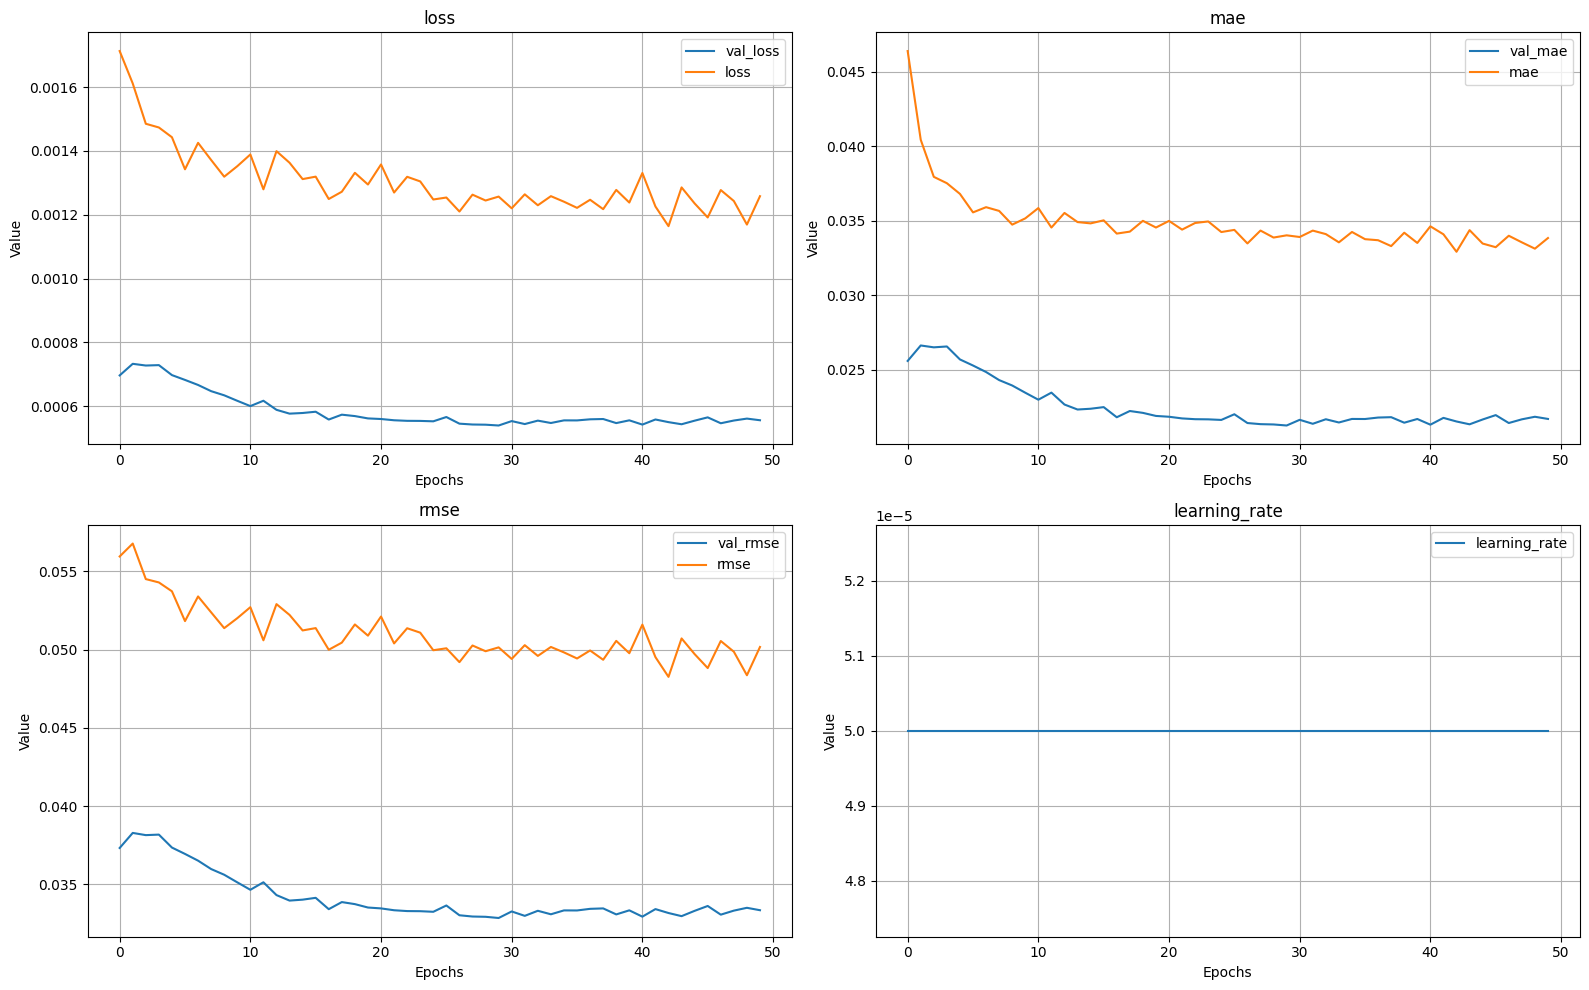

History saved to best_gru_history.csv


In [56]:
plot_history(history_tuned_gru, save_history_to_csv='best_gru_history.csv')

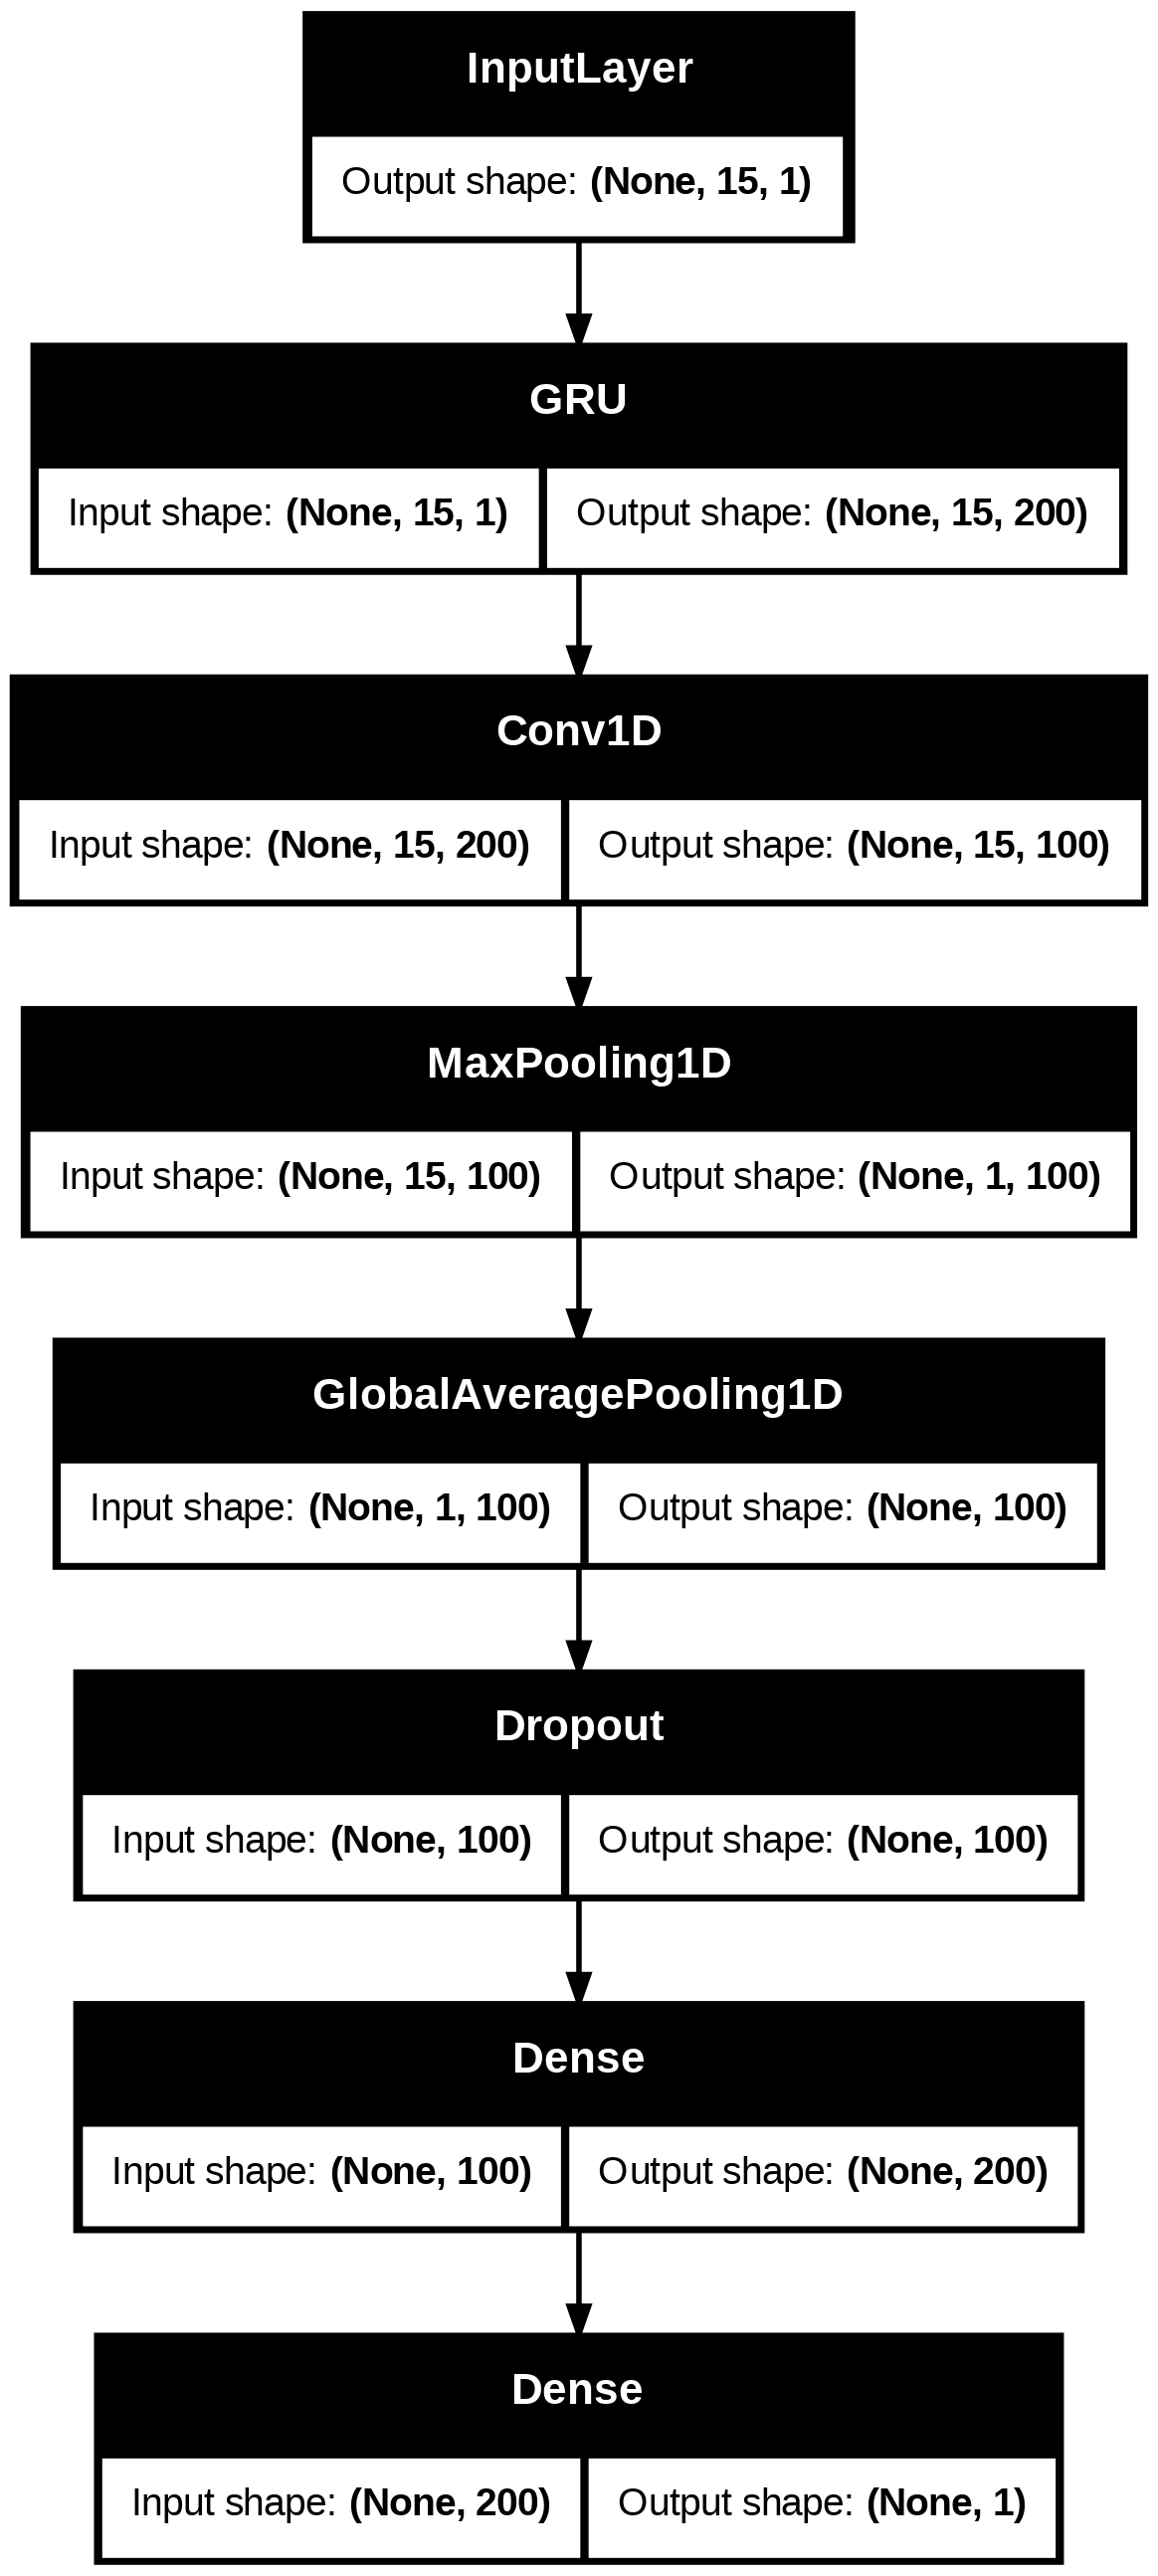

In [57]:
best_lstm_model.save('best_lstm_model_tuned_bayes_trained_10.keras')
tf.keras.utils.plot_model(best_lstm_model, to_file='model_graph_lstm_tuned.png', show_shapes=True)

best_gru_model.save('best_gru_model_tuned_bayes_trained_10.keras')
tf.keras.utils.plot_model(best_gru_model, to_file='model_graph_gru_tuned.png', show_shapes=True)

## Inference on Dataset

In [58]:
def compare_forecast_on_df(history, series, windowed_series, save_csv: str = None):
    forecast = history.model.predict(windowed_series)
    forecast = scaler.inverse_transform(forecast)
    
    forecast_df = pd.DataFrame(series['Close'][WINDOW_SIZE:])
    forecast_df['Close_Forecast'] = forecast

    if save_csv != None:
        forecast_df.to_csv(save_csv)
    return forecast_df

In [59]:
forecast_tuned_lstm_train_df = compare_forecast_on_df(history_tuned_lstm, train_series, train_windowed, save_csv='train_forecast_tuned_lstm.csv')
forecast_tuned_lstm_valid_df = compare_forecast_on_df(history_tuned_lstm, valid_series, valid_windowed, save_csv='valid_forecast_tuned_lstm.csv')

forecast_tuned_gru_train_df = compare_forecast_on_df(history_tuned_gru, train_series, train_windowed, save_csv='train_forecast_tuned_gru.csv')
forecast_tuned_gru_valid_df = compare_forecast_on_df(history_tuned_gru, valid_series, valid_windowed, save_csv='valid_forecast_tuned_gru.csv')

print('lstm trained forecast train')
display(forecast_tuned_lstm_train_df)


print('lstm trained forecast valid')
display(forecast_tuned_lstm_valid_df)

print('gru trained forecast train')
display(forecast_tuned_gru_train_df)

print('gru trained forecast valid')
display(forecast_tuned_gru_valid_df)

441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
      1/Unknown 0s 13ms/step

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
lstm trained forecast train


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


,Close,Close_Forecast
2002-01-23,10400.0,10370.500000
2002-01-24,10385.0,10369.401367
2002-01-25,10435.0,10370.395508
2002-01-28,10385.0,10367.064453
2002-01-29,10295.0,10365.081055
...,...,...
2019-10-01,14206.0,13990.510742
2019-10-02,14188.0,13996.562500
2019-10-03,14166.0,14004.471680
2019-10-06,14128.0,14020.702148


lstm trained forecast valid


,Close,Close_Forecast
2019-10-30,14018.000000,14063.169922
2019-10-31,14060.000000,14055.787109
2019-11-01,14123.500000,14043.641602
2019-11-04,14014.000000,14034.163086
2019-11-05,14058.000000,14021.367188
...,...,...
2023-12-26,15460.000000,15120.536133
2023-12-27,15400.000000,15113.063477
2023-12-28,15373.000000,15103.758789
2023-12-29,15425.000000,15094.306641


gru trained forecast train


,Close,Close_Forecast
2002-01-23,10400.0,10427.419922
2002-01-24,10385.0,10426.744141
2002-01-25,10435.0,10426.671875
2002-01-28,10385.0,10423.083984
2002-01-29,10295.0,10420.104492
...,...,...
2019-10-01,14206.0,14105.495117
2019-10-02,14188.0,14117.884766
2019-10-03,14166.0,14126.073242
2019-10-06,14128.0,14142.521484


gru trained forecast valid


,Close,Close_Forecast
2019-10-30,14018.000000,14186.218750
2019-10-31,14060.000000,14176.992188
2019-11-01,14123.500000,14162.564453
2019-11-04,14014.000000,14152.014648
2019-11-05,14058.000000,14137.090820
...,...,...
2023-12-26,15460.000000,15331.364258
2023-12-27,15400.000000,15321.548828
2023-12-28,15373.000000,15314.145508
2023-12-29,15425.000000,15310.388672


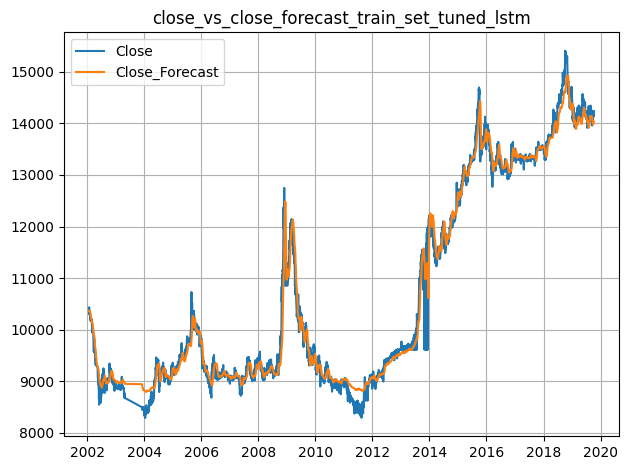

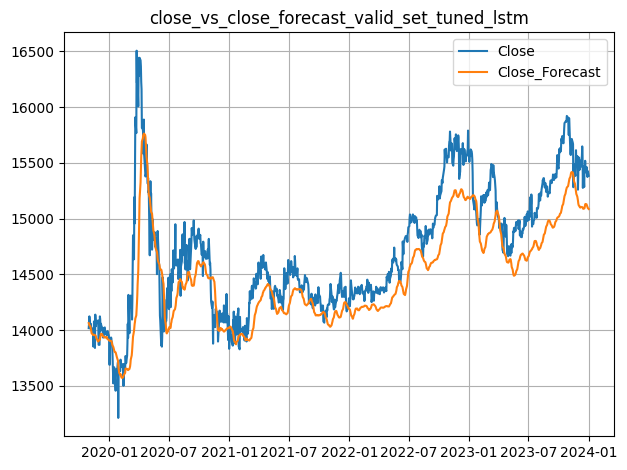

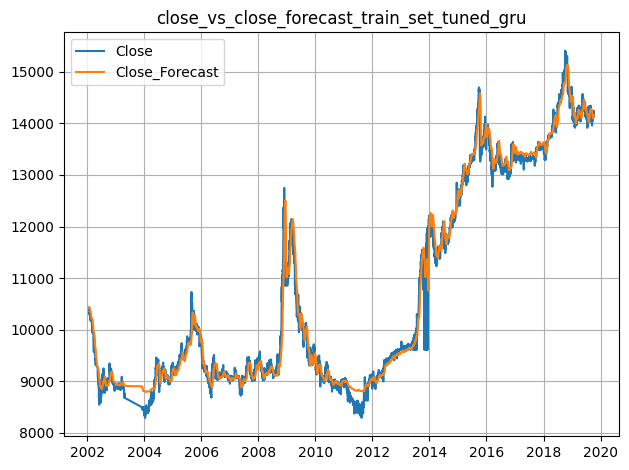

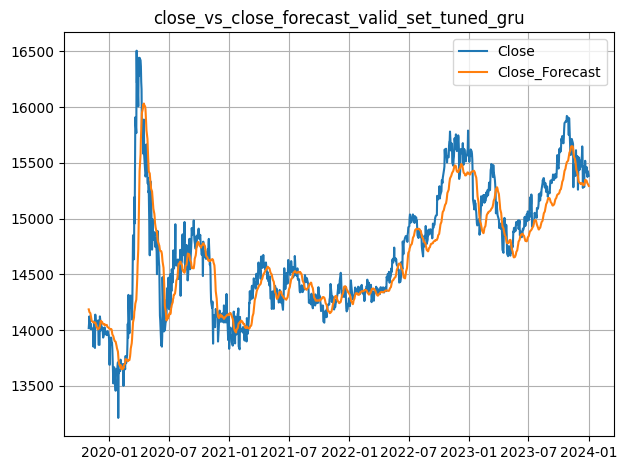

In [60]:
# @title Plot comparison trained forecast value on train set and valid set

plot_compare(forecast_tuned_lstm_train_df, forecast_tuned_lstm_train_df.columns, title='close_vs_close_forecast_train_set_tuned_lstm', save_fig='close_vs_close_forecast_train_set_tuned_lstm.png')
plot_compare(forecast_tuned_lstm_valid_df, forecast_tuned_lstm_valid_df.columns, title='close_vs_close_forecast_valid_set_tuned_lstm', save_fig='close_vs_close_forecast_valid_set_tuned_lstm.png')

plot_compare(forecast_tuned_gru_train_df, forecast_tuned_gru_train_df.columns, title='close_vs_close_forecast_train_set_tuned_gru', save_fig='close_vs_close_forecast_train_set_tuned_gru.png')
plot_compare(forecast_tuned_gru_valid_df, forecast_tuned_gru_valid_df.columns, title='close_vs_close_forecast_valid_set_tuned_gru', save_fig='close_vs_close_forecast_valid_set_tuned_gru.png')